<div style="text-align: center; margin: auto; background:#b4cc3d; padding:10px; color:white; font-family:Calibri ;">
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTaJWG7PzF3toxaRMB1-JicpqMgJuEXATd0fg&" style="width:120px; padding-top: 20px;">
    <h1  style="font-size:2.8rem">Data Mining Project: ABCDEats Customer Data</h1>
    <h2  style="font-size:2rem">Value Based Segmentation</h2>
    <p style='font-size:1.2rem;'>NOVA Information Management School </p>    
    <p style='font-size:1.2rem;'>Master in Data Science and Advanced Analytics</p>    
    <img src="https://cdni.iconscout.com/illustration/premium/thumb/food-delivery-service-by-scooter-illustration-download-in-svg-png-gif-file-formats--on-pack-e-commerce-shopping-illustrations-4403764.png" style="width:33rem;">
    <p style='font-size:1.3rem; padding:0; margin:0; font-weight:bold;'>Group 41 members:</p>
    <ul style='font-size:1.2rem; list-style-position: inside; padding-left:0; border:none;'>
        <li>Elcano Gaspar (20241021)</li>
        <li>Gasper Pereira (20230984)</li>
        <li>Pedro Costa (20222121)</li>
        <li>Rita Wang (20240551)</li>
    </ul> 
    <br>
    <p style='font-size:1.2rem; '>      Fall/Spring Semester 2024-2025</p>
</div>

<h1>0. Imports and Dataset Loading</h1>

In [1]:
# !pip install minisom
# !pip install minisom --upgrade
# !pip install sns --upgrade
#!pip install --upgrade pip setuptools wheel

In [2]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as GridSpec
import warnings

from itertools import combinations
from collections import Counter


from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


from functions import * 

from scipy.stats import skew
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering


from minisom import MiniSom
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm


In [3]:
df = pd.read_csv("PREPROCESSED_DATASET.csv")

# Features selected for Value-Behavior

In [4]:
value_cols = ['total_spent_log',
                'total_orders_log',
                'spend_per_vendor_log',
                "total_spent_chain_log"]

In [5]:
df[value_cols].describe().T

count      mean       std  min       25%       50%  \
total_spent_log        30405.0  0.595231  0.133724  0.0  0.509930  0.600280   
total_orders_log       30405.0  0.268843  0.216985  0.0  0.155787  0.266320   
spend_per_vendor_log   30405.0  0.498925  0.153226  0.0  0.389090  0.500393   
total_spent_chain_log  30405.0  0.425208  0.241552  0.0  0.331481  0.474843   

                            75%  max  
total_spent_log        0.685081  1.0  
total_orders_log       0.422107  1.0  
spend_per_vendor_log   0.611979  1.0  
total_spent_chain_log  0.592358  1.0

In [6]:
missing_data(df[value_cols])

Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []

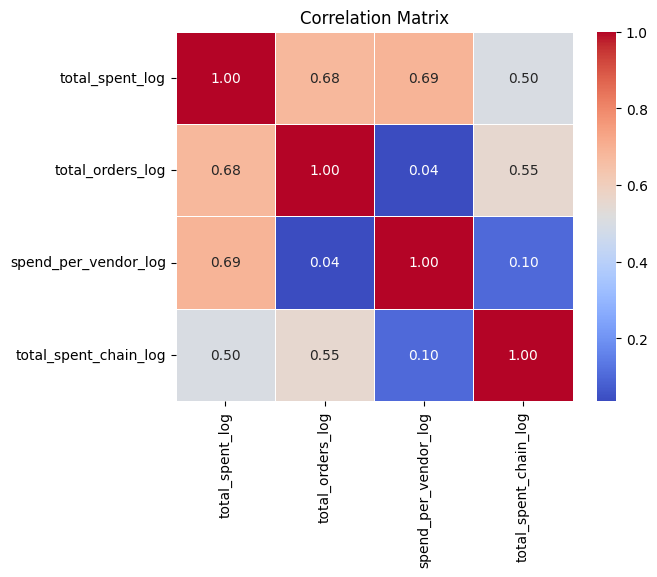

In [7]:

sns.heatmap(df[value_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


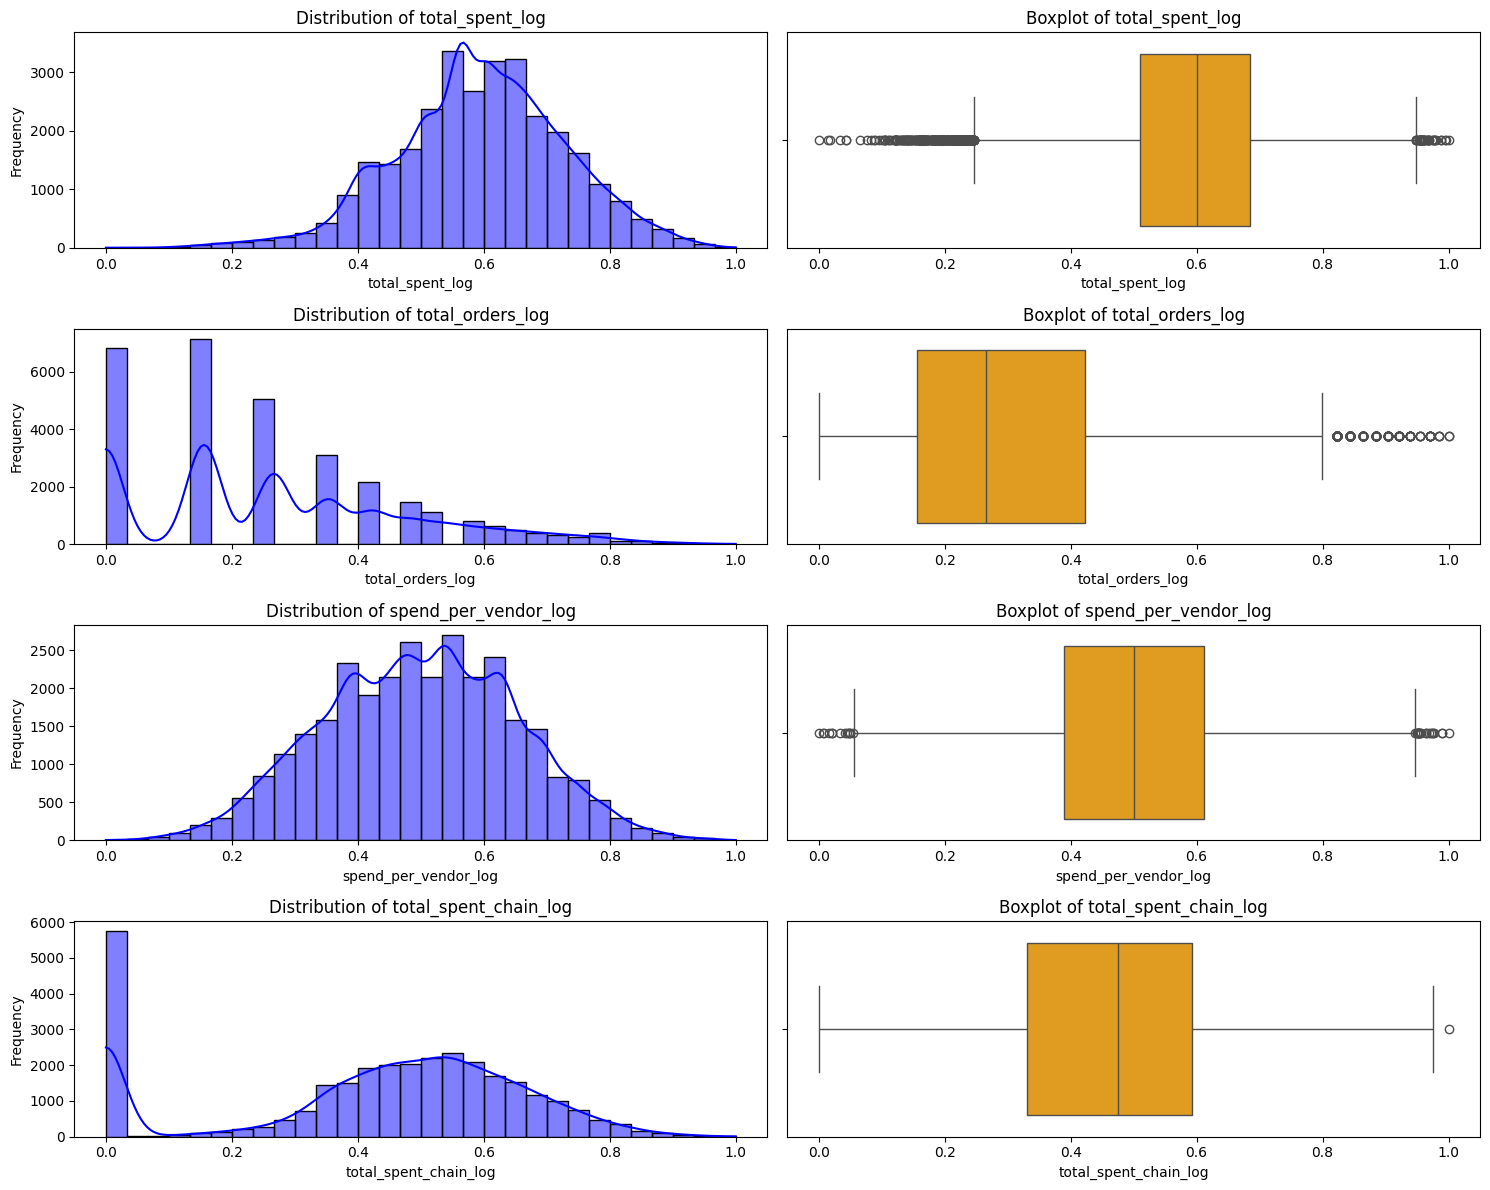

In [8]:
plot_distribution_and_boxplot(df, value_cols)

# Hierarchical Clustering

C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\2885063615.py:12: UserWarning: The markers list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


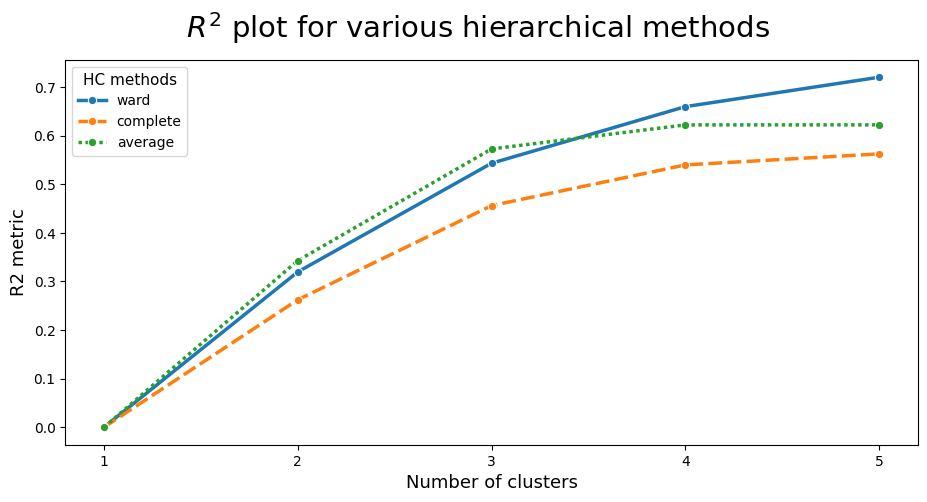

In [9]:
hc_methods = ["ward", "complete", "average"] #single
max_nclus = 5
r2_hc = np.vstack([ get_r2_hc(df[value_cols],
                              link,
                              max_nclus=max_nclus,
                              min_nclus=1,
                              dist="euclidean")
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)
plt.show()


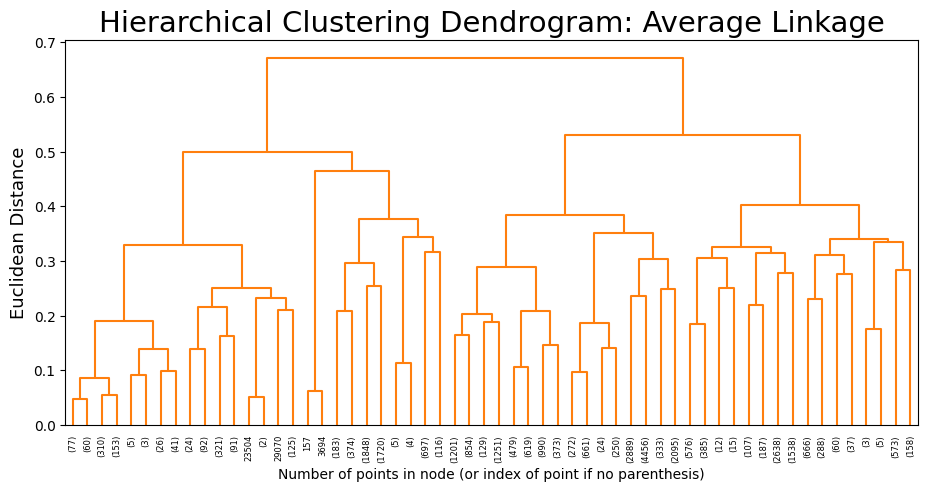

In [10]:

link = 'average'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)

hclust.fit_predict(df[value_cols])

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 165
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()




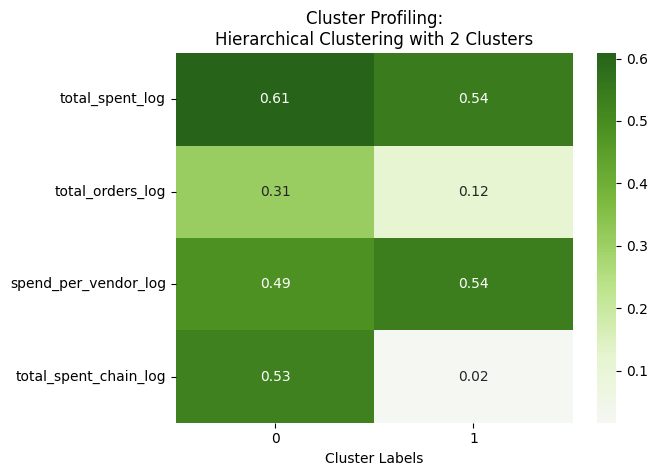

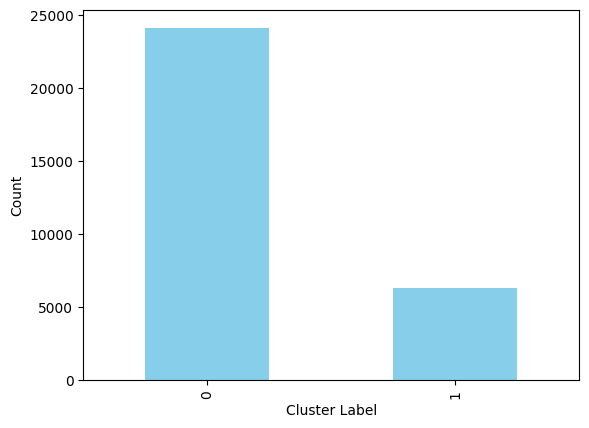

In [11]:

hc_clust = AgglomerativeClustering(n_clusters=2, linkage="average", metric="euclidean")
hc_labels = hc_clust.fit_predict(df[value_cols])


df_concat = pd.concat((df[value_cols], pd.Series(hc_labels, name='labels', index=df.index)), axis=1)

sns.heatmap(df_concat.groupby('labels')[value_cols].mean().T, center=0, annot=True, cmap="PiYG", fmt=".2f")
plt.xlabel("Cluster Labels")
plt.title("Cluster Profiling:\nHierarchical Clustering with 2 Clusters")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [12]:
r2_all = []
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.3428040948548586

# KMeans

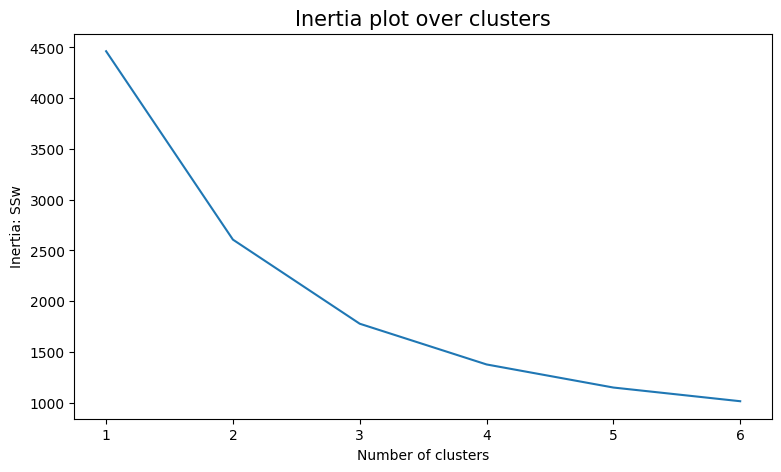

In [13]:
range_clusters = range(1, 7)
inertia = []

for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[value_cols])
    inertia.append(kmclust.inertia_)

fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()


In [14]:
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

avg_silhouette = []

for nclus in range_clusters:
    if nclus == 1:
        continue

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[value_cols])

    silhouette_avg = silhouette_score(df[value_cols], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")


For n_clusters = 2, the average silhouette_score is : 0.3483911709028925
For n_clusters = 3, the average silhouette_score is : 0.3824793285759385
For n_clusters = 4, the average silhouette_score is : 0.35107846672499765
For n_clusters = 5, the average silhouette_score is : 0.34352972674540744
For n_clusters = 6, the average silhouette_score is : 0.3333105000775654


In [15]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[value_cols])

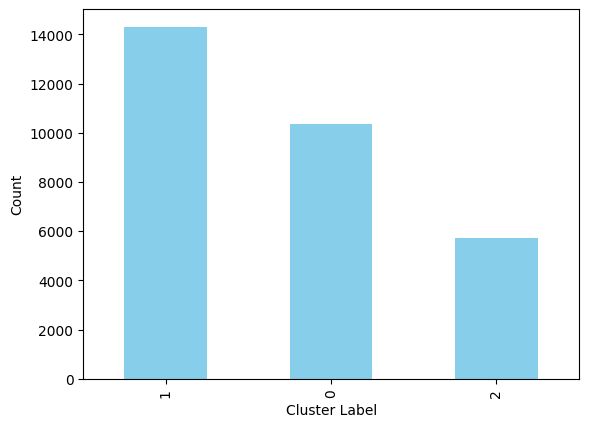

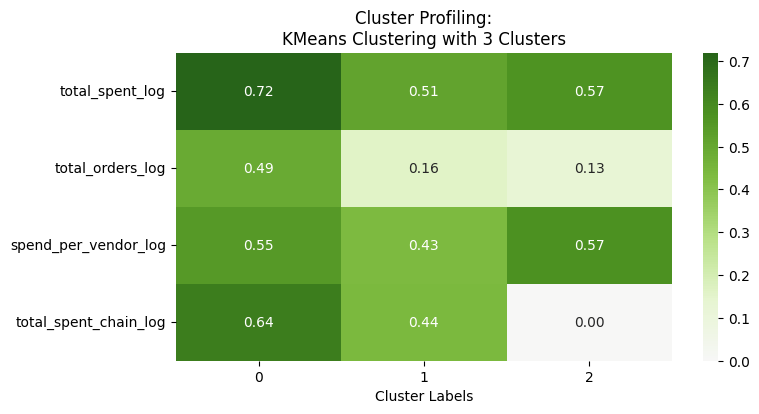

In [16]:
df_concat = pd.concat((df[value_cols], pd.Series(km_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()


In [17]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6014814456162794

# SOM (Emergent SOM)

In [18]:

neigh = 'gaussian'
topol = 'hexagonal'
n_feats = len(value_cols)
activation_distc = 'euclidean'

som_data = df[value_cols].values

In [19]:
from numpy.linalg import eig


cov_matrix = np.cov(df[value_cols].T)

eigenvalues, _ = eig(cov_matrix)
eigenvalues = sorted(eigenvalues.round(3), reverse=True)
ratio = eigenvalues[0] / eigenvalues[1]
ratio.round(2)

3.07

In [20]:
grid_size = 4_000 
M = np.sqrt(grid_size * ratio).round().astype(int)
N = (grid_size / M).round().astype(int)
print(f"M: {M}, N: {N}")

M: 111, N: 36


In [21]:

n_feats = len(value_cols)

learning_rates = [0.5] # 0.3, 0.6 
sigmas = [3] # 1, 1.5, 2, 2.5
epochs_list = [500_000]

som_data = df[value_cols].values

best_te = float('inf')
best_params = {}

for lr in learning_rates:
    for sigma in sigmas:
        sm = MiniSom(M, N, n_feats, sigma=sigma, learning_rate=lr, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)
        sm.random_weights_init(som_data)
        
        print(f"Pre training QE: {sm.quantization_error(som_data)}")
        print(f"Pre training TE: {sm.topographic_error(som_data)}")
        
        sm.train_batch(som_data, epochs_list[0])

        qe = sm.quantization_error(som_data)
        te = sm.topographic_error(som_data)

        print(f"LR: {lr}, Sigma: {sigma}, Epochs: {epochs_list[0]} -> QE: {qe:.3f}, TE: {te:.3f}")

        # Update best parameters based on TE
        if te < best_te:
            best_te = te
            best_params = {'learning_rate': lr, 'sigma': sigma, 'epochs': epochs_list[0]}


best_params

C:\Users\Elcano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Pre training QE: 0.010955207848320178
Pre training TE: 0.9986515375760566
LR: 0.5, Sigma: 3, Epochs: 500000 -> QE: 0.016, TE: 0.095


{'learning_rate': 0.5, 'sigma': 3, 'epochs': 500000}

In [22]:
sm = MiniSom(M, N, n_feats, sigma=3, learning_rate=0.5, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)

sm.random_weights_init(som_data)

print("Before training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")

sm.train_batch(som_data, 500_000)

print("After training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")


Before training:
QE: 0.011
TE: 0.999
After training:
QE: 0.016
TE: 0.095


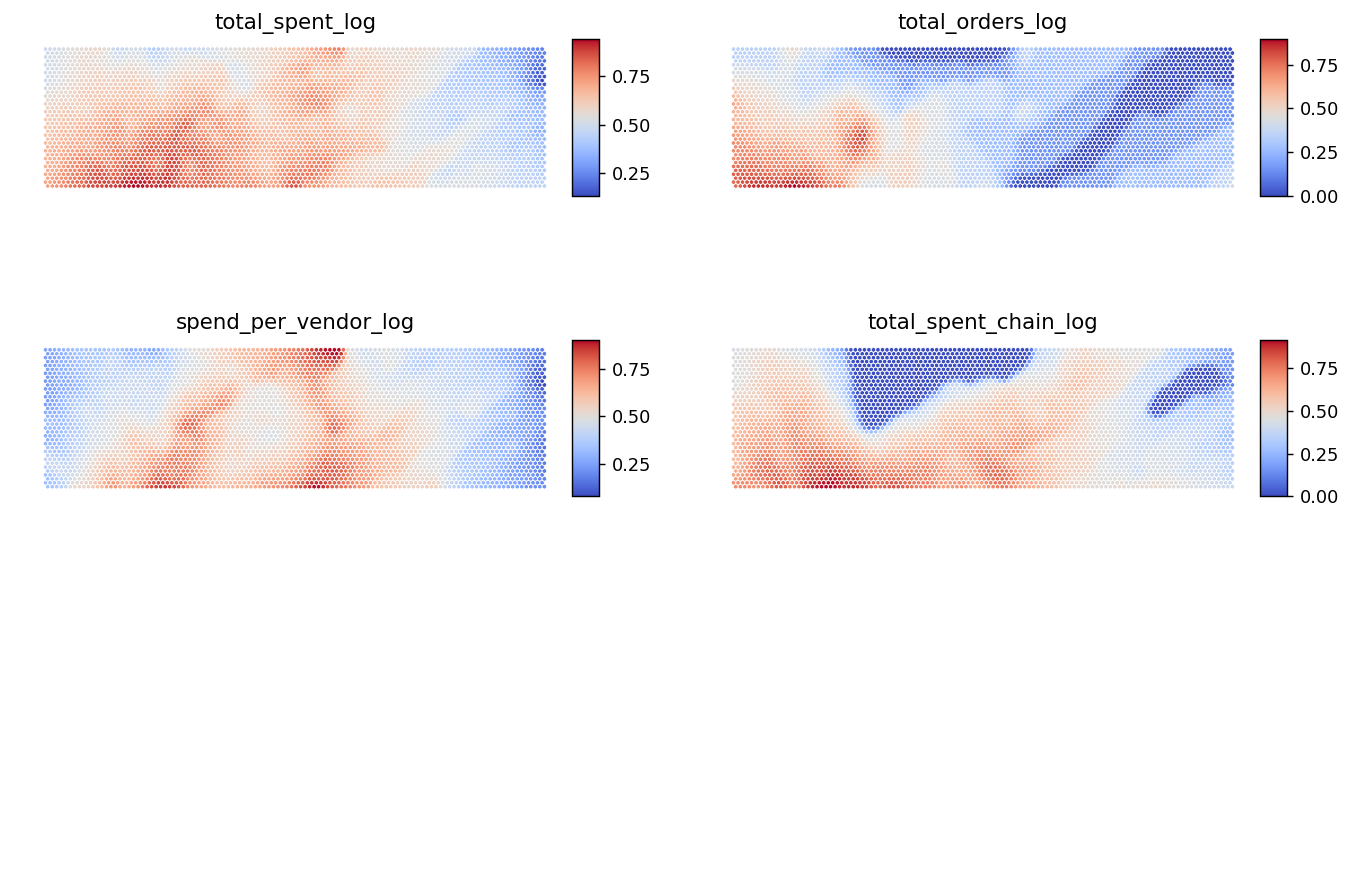

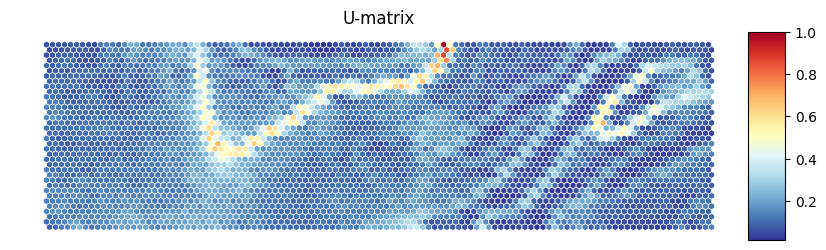

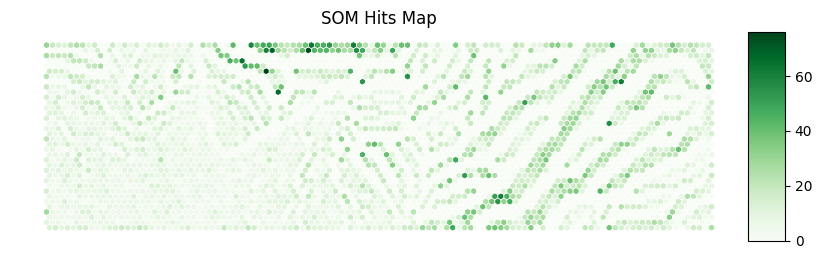

In [23]:
weights = sm.get_weights()
weights.shape
figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )
subfigs = fig.subfigures(3,2,wspace=.15)
colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
for cpi, sf in zip(range(len(value_cols)), subfigs.flatten()):
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    #colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)
    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=value_cols[cpi],
                    cmap=cm.coolwarm,
                    )
    
    
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )


hitsmatrix = sm.activation_response(df[value_cols].values)
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )

In [24]:
weights_flat = sm.get_weights().reshape((M*N),len(value_cols))
weights_flat.shape

(3996, 4)

# KMeans on SOM

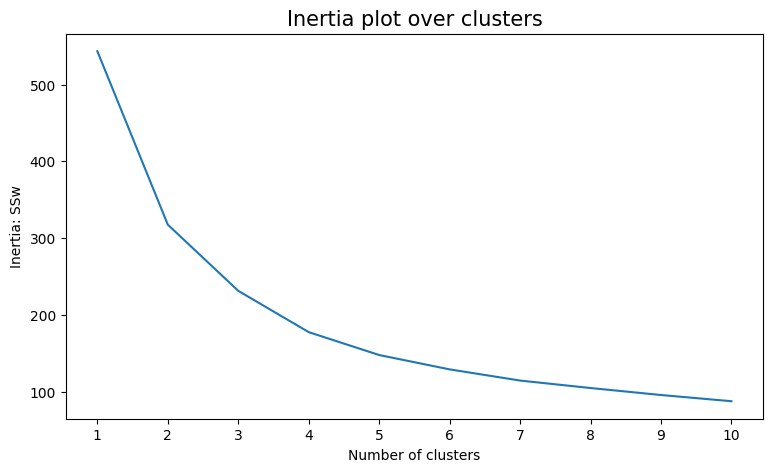

In [25]:

range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(weights_flat)
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()

In [26]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(weights_flat)

    silhouette_avg = silhouette_score(weights_flat, cluster_labels, metric='euclidean')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.3489545023655526
For n_clusters = 3, the average silhouette_score is : 0.3608350574633661
For n_clusters = 4, the average silhouette_score is : 0.3328284573938444
For n_clusters = 5, the average silhouette_score is : 0.32446825090208276
For n_clusters = 6, the average silhouette_score is : 0.3102183992785126
For n_clusters = 7, the average silhouette_score is : 0.3102393691382816
For n_clusters = 8, the average silhouette_score is : 0.30352051924203044
For n_clusters = 9, the average silhouette_score is : 0.2923481280678005
For n_clusters = 10, the average silhouette_score is : 0.29079844175166497


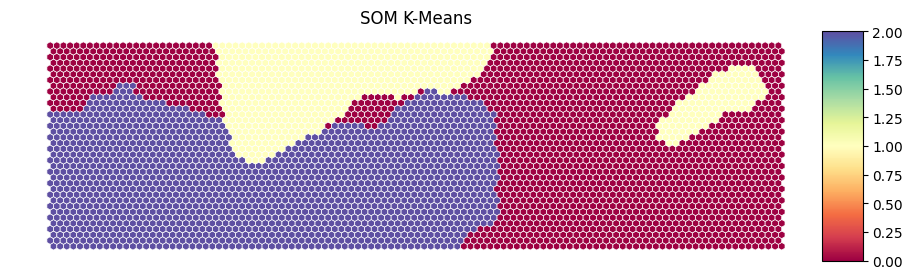

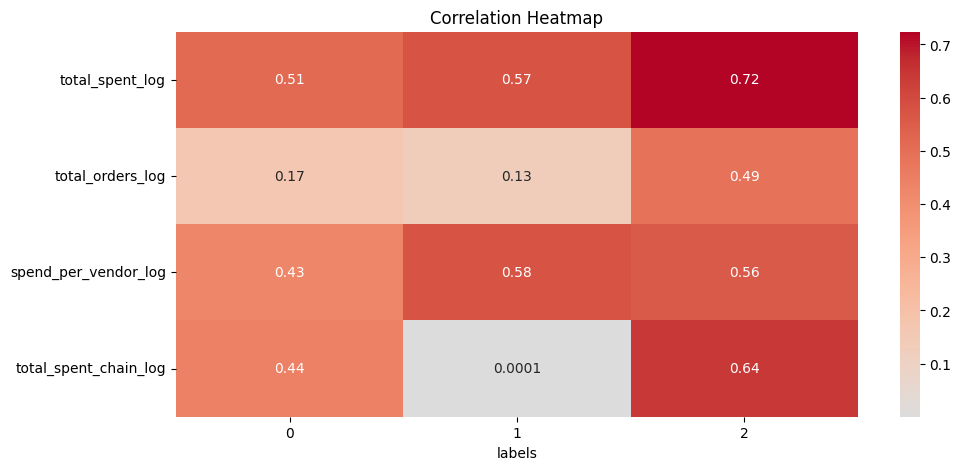

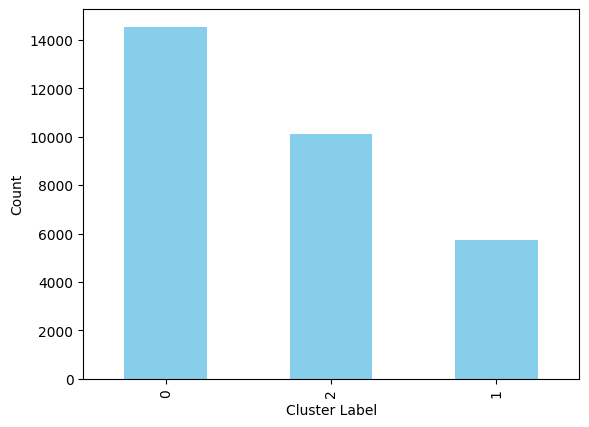

In [27]:

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)

nodeclus_labels = kmeans.fit_predict(weights_flat)

kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )


nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=value_cols)
df_nodes['label'] = nodeclus_labels

# shape df.shape[0], 2 dimension 
bmu_index = np.array([sm.winner(x) for x in df[value_cols].values])
som_final_labels = [kmeans_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[value_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [28]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6001844375287018

# Hierarchical on SOM

C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\2219672209.py:14: UserWarning: The markers list has more values (4) than needed (3), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


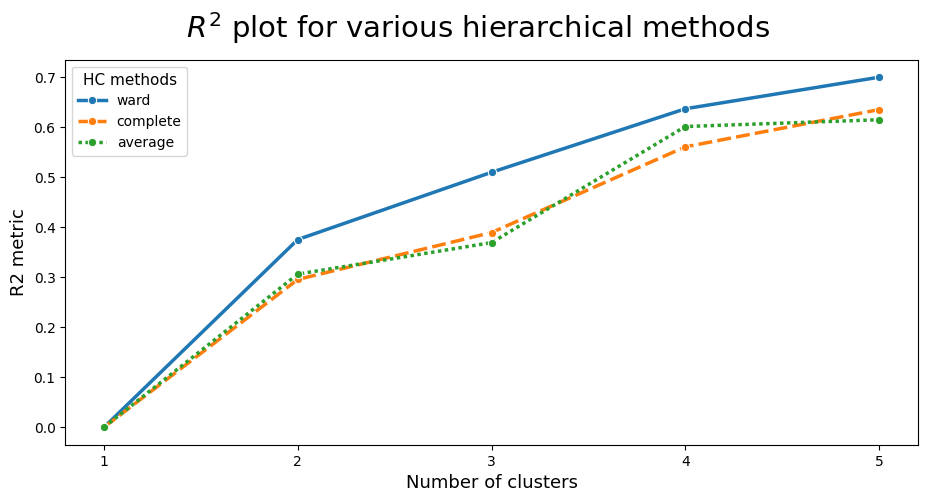

In [29]:
weights_flat = pd.DataFrame(weights_flat, columns=value_cols)

hc_methods = ["ward", "complete", "average"] #r2
max_nclus = 5
r2_hc = np.vstack([ get_r2_hc(weights_flat,
                              link,
                              max_nclus=max_nclus,
                              min_nclus=1,
                              dist="euclidean")
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(1, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
fig.suptitle("$R^2$ plot for various hierarchical methods", fontsize=21)
plt.show()

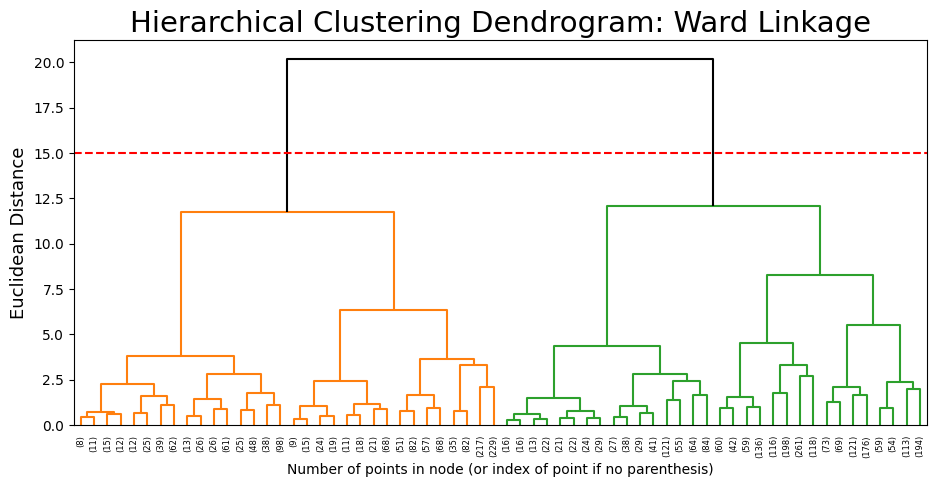

In [30]:
link = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)

hclust.fit_predict(weights_flat)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 15
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()


In [31]:
avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue

    hc = AgglomerativeClustering(linkage="ward", metric="euclidean", n_clusters=nclus)
    hc_clust = hc.fit_predict(weights_flat)

    silhouette_avg = silhouette_score(weights_flat, hc_clust, metric='euclidean')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.3293498154789017
For n_clusters = 3, the average silhouette_score is : 0.2582789504816124
For n_clusters = 4, the average silhouette_score is : 0.2910131034658329
For n_clusters = 5, the average silhouette_score is : 0.284435506868868
For n_clusters = 6, the average silhouette_score is : 0.27869040746046714
For n_clusters = 7, the average silhouette_score is : 0.2698630421606857
For n_clusters = 8, the average silhouette_score is : 0.2537295983274252
For n_clusters = 9, the average silhouette_score is : 0.2538199646622413
For n_clusters = 10, the average silhouette_score is : 0.2354603242445323


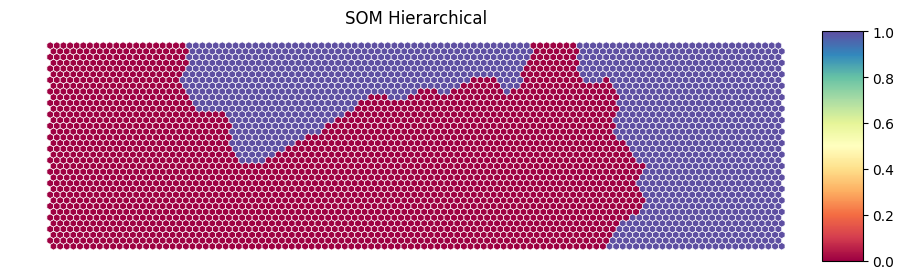

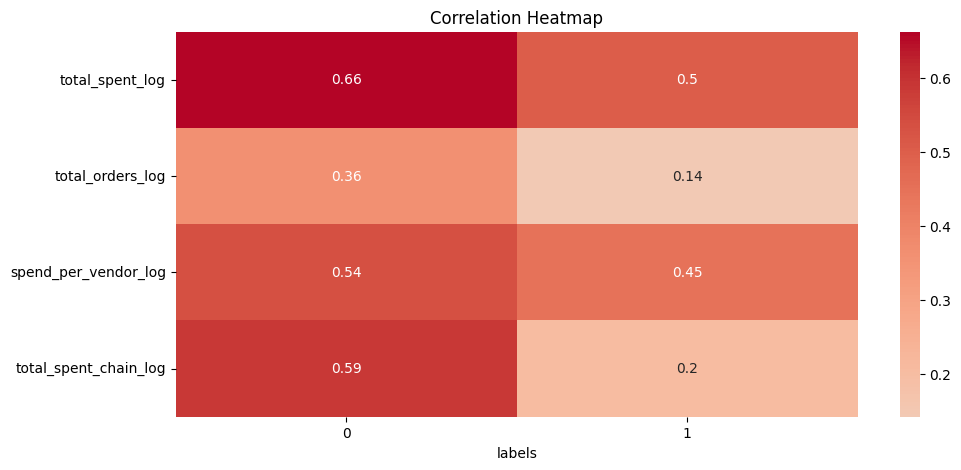

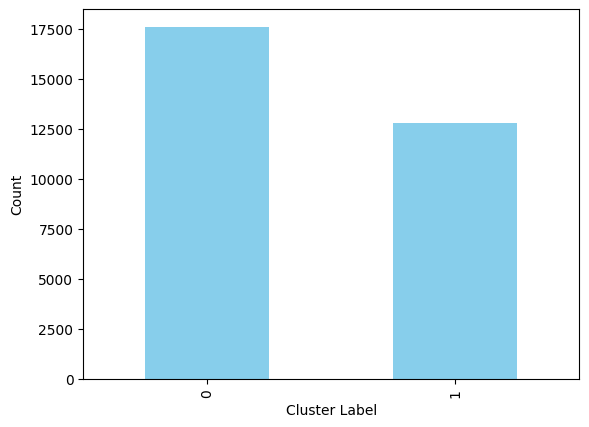

In [32]:

hc_clust = AgglomerativeClustering(n_clusters=2, linkage="ward", metric="euclidean")
nodeclus_labels = hc_clust.fit_predict(weights_flat)

hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )



nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=value_cols)
df_nodes['label'] = nodeclus_labels

bmu_index = np.array([sm.winner(x) for x in df[value_cols].values])

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[value_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [33]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.37868333742545957

# Gaussian Mixture Model

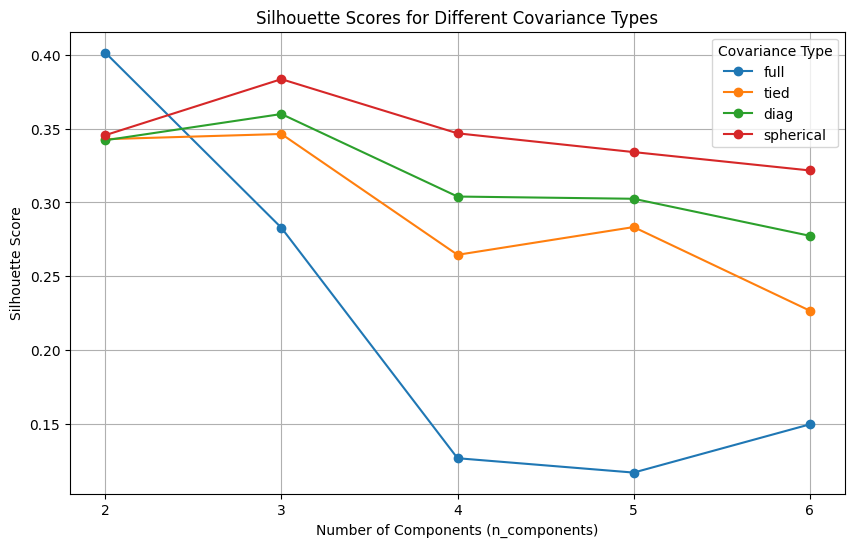

In [34]:
n_components = np.arange(2, 7)  
cov_types = ['full', 'tied', 'diag', 'spherical']  
scores = {cova: [] for cova in cov_types}  


for cova in cov_types:
    for n in n_components:
        model = GaussianMixture(n_components=n, covariance_type=cova, n_init=10, init_params='kmeans', random_state=42)
        model.fit(df[value_cols]) 
        
        gm_labels = model.predict(df[value_cols])
        
        score = silhouette_score(df[value_cols], gm_labels, metric='euclidean', random_state=42)
        scores[cova].append(score) 

plt.figure(figsize=(10, 6))
for cova in cov_types:
    plt.plot(n_components, scores[cova], marker='o', label=f'{cova}')

plt.title('Silhouette Scores for Different Covariance Types')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(n_components)
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


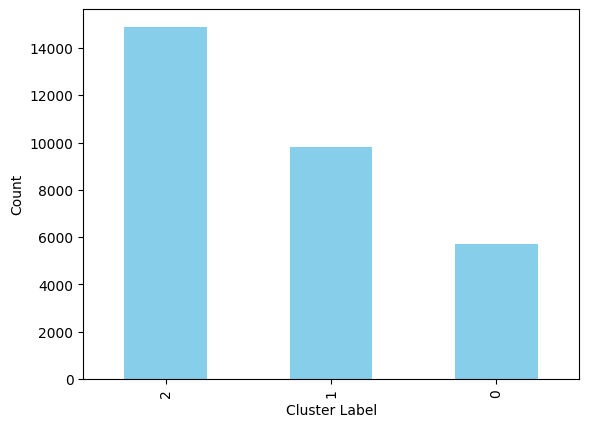

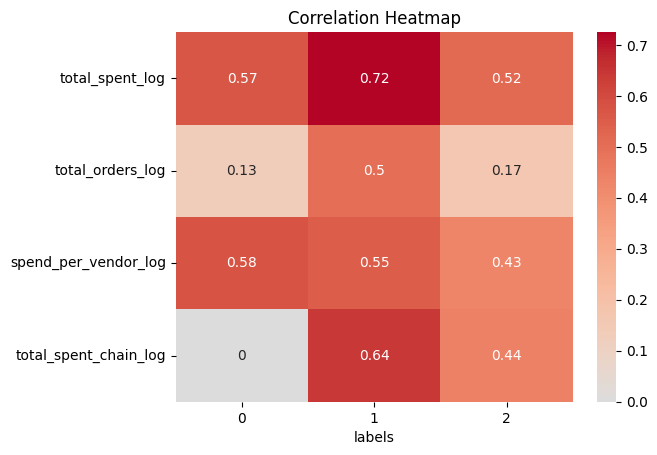

In [35]:

gm = GaussianMixture(n_components=3, covariance_type='spherical', n_init=10, init_params='kmeans', random_state=42)
gm_labels = gm.fit_predict(df[value_cols])

df_concat = pd.concat((df[value_cols], pd.Series(gm_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [36]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2_all.append(r2)
r2

0.6005103319073133

In [37]:
r2_all

[0.3428040948548586,
 0.6014814456162794,
 0.6001844375287018,
 0.37868333742545957,
 0.6005103319073133]

# Comparison of Clustering Methods for Value-Behavior

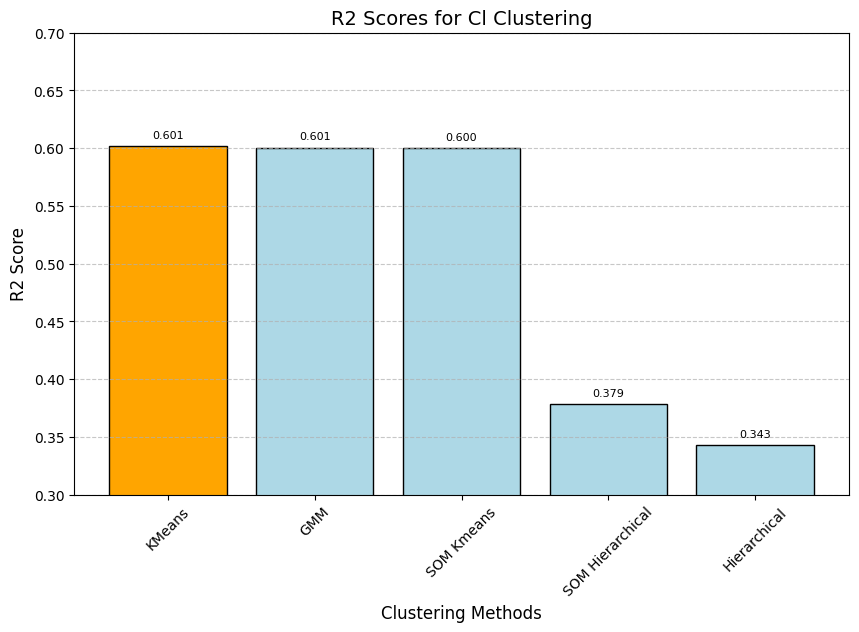

In [38]:

plt.figure(figsize=(10, 6))
methods = ['Hierarchical', 'KMeans', 'SOM Kmeans', "SOM Hierarchical", 'GMM']

sorted_indices = np.argsort(r2_all)[::-1]
methods = [methods[i] for i in sorted_indices] 
r2_all = [r2_all[i] for i in sorted_indices] 


bars = plt.bar(methods, r2_all, color='lightblue', edgecolor='black')

max_index = r2_all.index(max(r2_all))
bars[max_index].set_color('orange')
bars[max_index].set_edgecolor('black')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{r2_all[i]:.3f}',
             ha='center', va='bottom', fontsize=8, color='black')

plt.title('R2 Scores for Cl Clustering', fontsize=14)
plt.xlabel('Clustering Methods', fontsize=12)
plt.ylabel('R2 Score', fontsize=12)
plt.ylim(0.3, 0.7)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45) 
plt.show()

# Final Solution

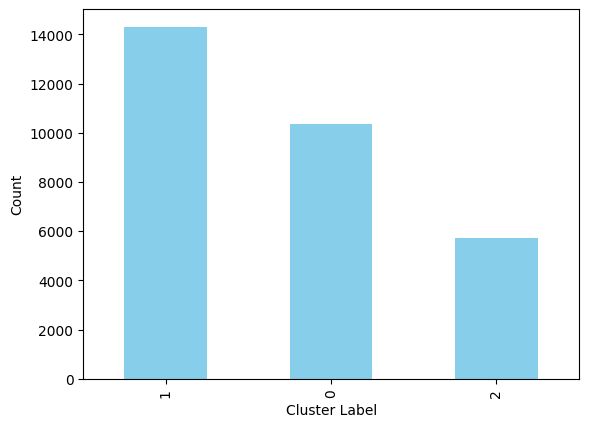

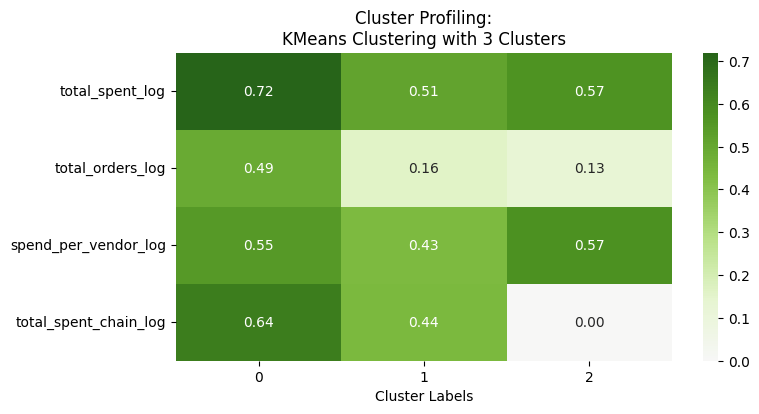

In [39]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[value_cols])

df_concat = pd.concat((df[value_cols], pd.Series(km_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')

fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()

In [40]:
r2 = get_rsq(df_concat, value_cols, 'labels')
r2

0.6014814456162794

## Features selected for Preference

In [41]:
selected_features_percent = ["Asian_Street_percent", "Other_Chinese_percent", "Italian_American_percent", "AM_preference_percent"]

preferences_cols = selected_features_percent

# Hierarchical Clustering

C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\4286413069.py:12: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


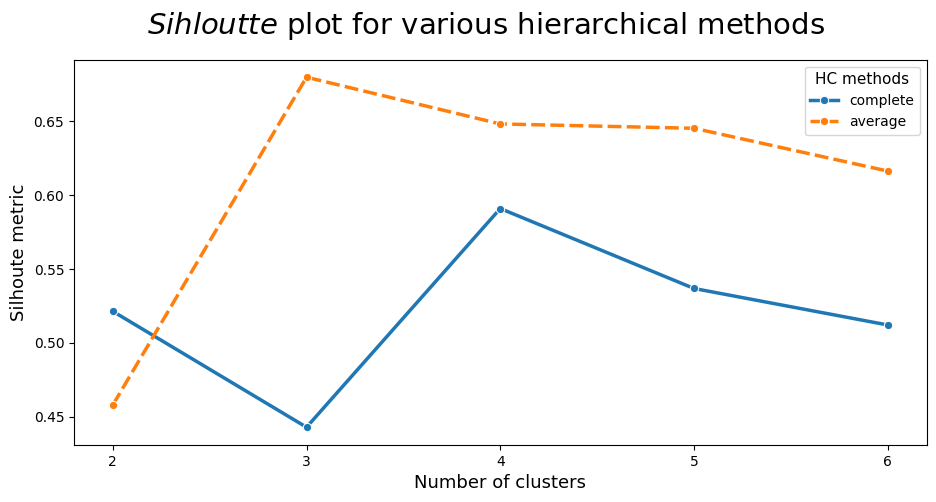

In [42]:

hc_methods = ["complete", "average"] # ward doesnt work with cosine distances / single always bad
max_nclus = 6
r2_hc = np.vstack([ get_silhouette_hc(df[preferences_cols], 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=2, 
                              dist="cosine") 
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(2, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(2, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("Silhoute metric", fontsize=13)
fig.suptitle("$Sihloutte$ plot for various hierarchical methods", fontsize=21)
plt.show()

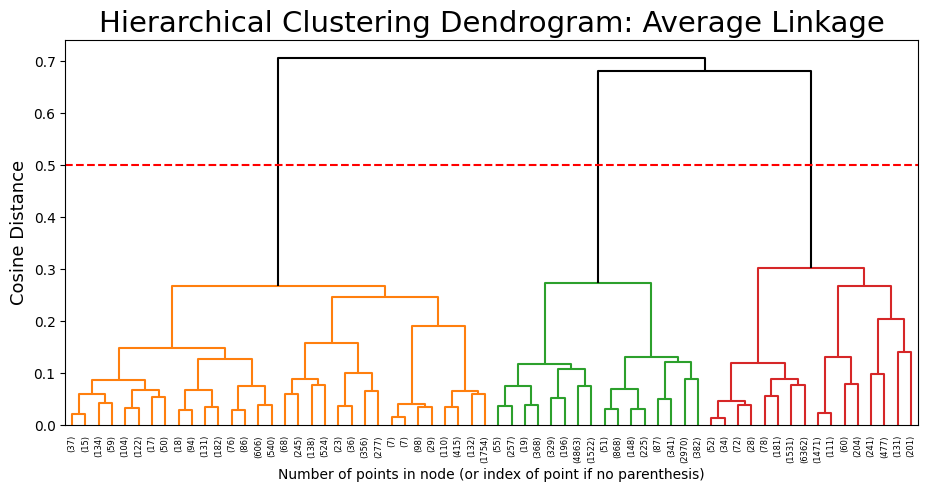

In [43]:

link = 'average'
distance = 'cosine'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[preferences_cols])

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 0.5
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

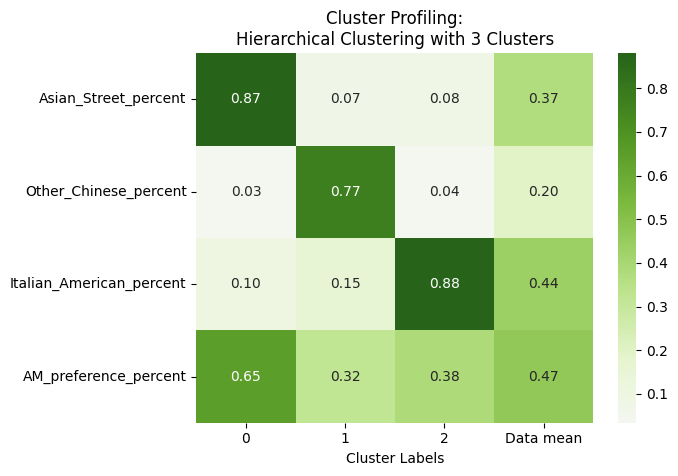

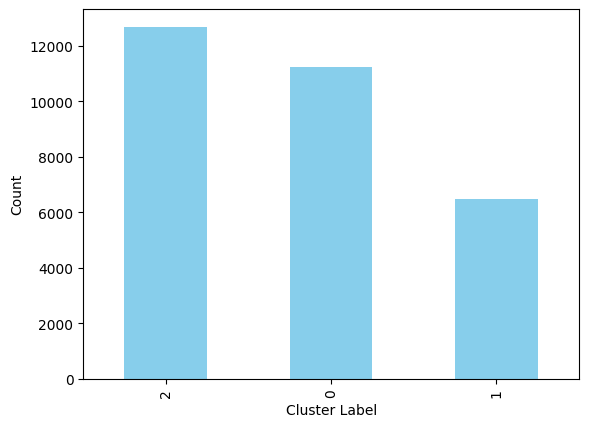

In [44]:


hc_clust = AgglomerativeClustering(n_clusters=3, linkage="average", metric="cosine")
hc_labels = hc_clust.fit_predict(df[preferences_cols])


df_concat = pd.concat((df[preferences_cols], pd.Series(hc_labels, name='labels', index=df.index)), axis=1)

cluster_means = df_concat.groupby('labels')[preferences_cols].mean().T
overall_means = df[preferences_cols].mean()
overall_means.name = "Data mean"

cluster_means = pd.concat((cluster_means, overall_means), axis=1)
# df_concat = pd.concat((df_concat.T, df_means), axis=1)
# r2 = get_rsq(df_concat, preferences_cols, 'labels')

sns.heatmap(cluster_means, center=0, annot=True, cmap="PiYG", fmt=".2f")
plt.xlabel("Cluster Labels")
plt.title("Cluster Profiling:\nHierarchical Clustering with 3 Clusters")
plt.show()


df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [45]:
silhouettes_avgs = []
silho = silhouette_score(df[preferences_cols], hc_labels, metric='cosine')
silhouettes_avgs.append(silho)
silho

0.6794453652602869

# KMeans Clustering 

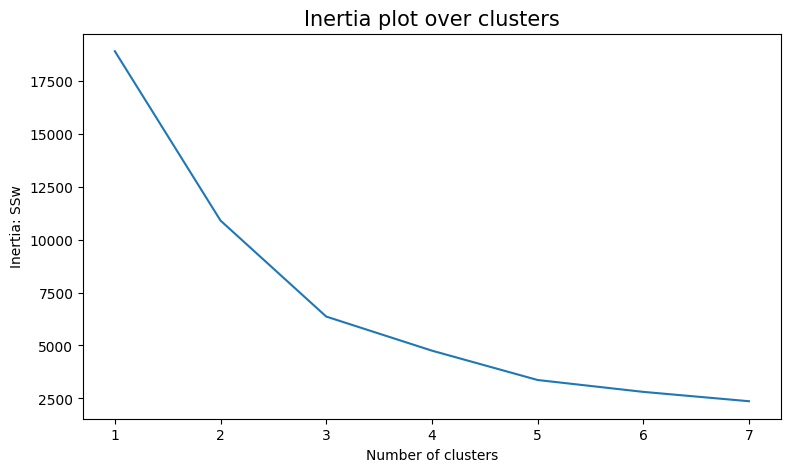

In [46]:

range_clusters = range(1, 8)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[preferences_cols])
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.533317284437143
For n_clusters = 3, the average silhouette_score is : 0.7030190108470945
For n_clusters = 4, the average silhouette_score is : 0.6449311947866948
For n_clusters = 5, the average silhouette_score is : 0.624497399143215
For n_clusters = 6, the average silhouette_score is : 0.6089715649410746
For n_clusters = 7, the average silhouette_score is : 0.5980096249036736


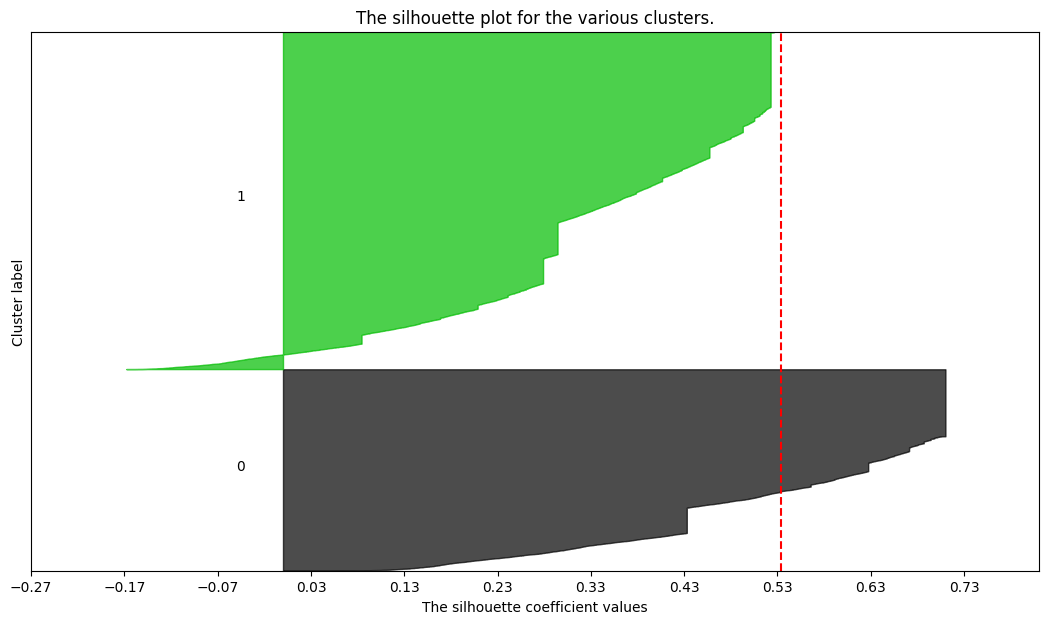

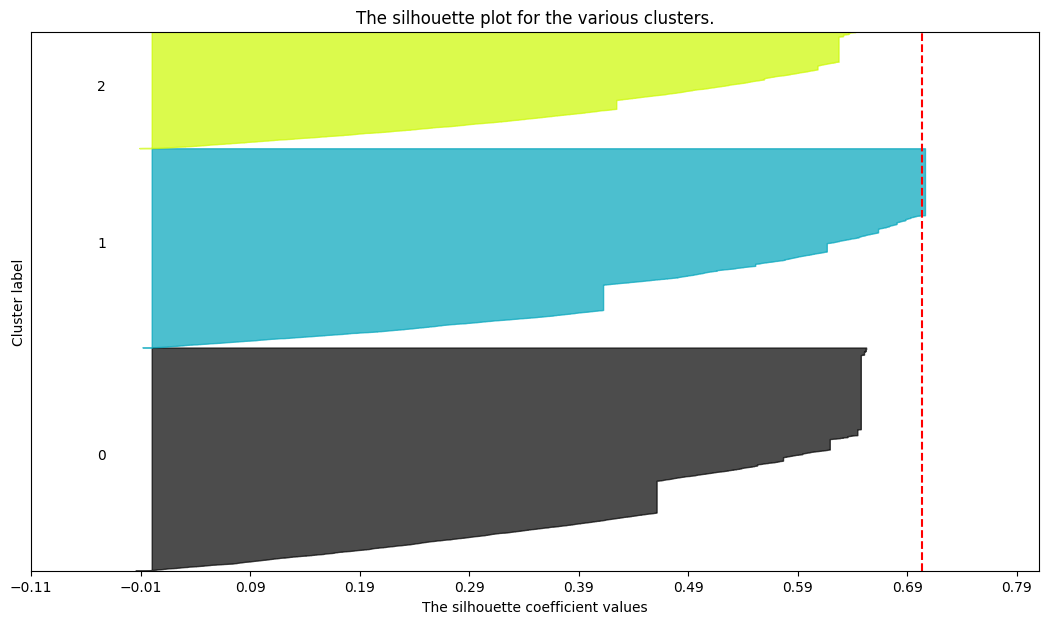

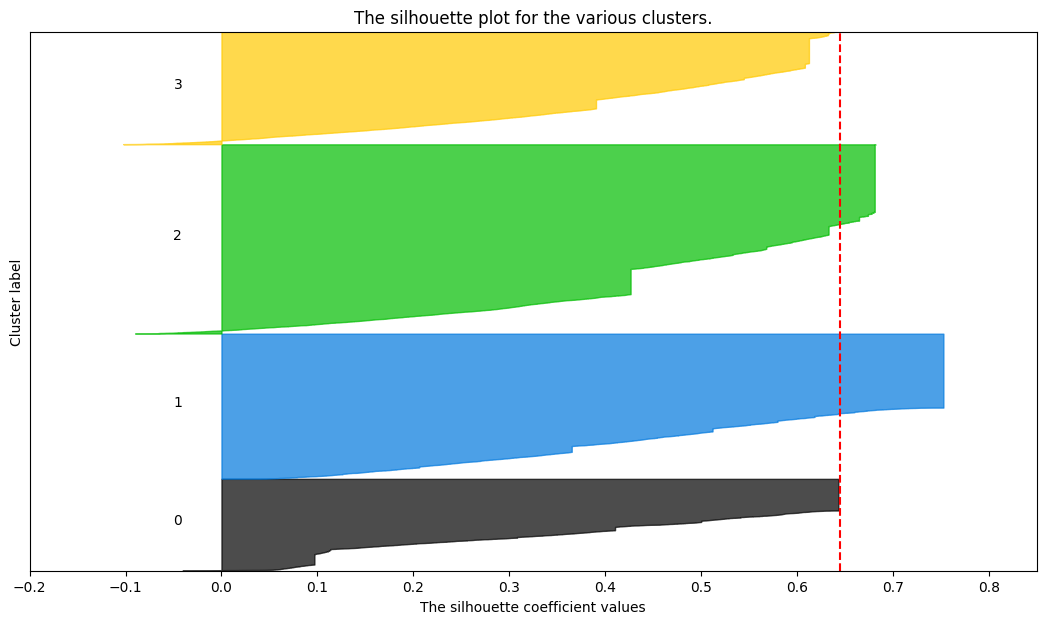

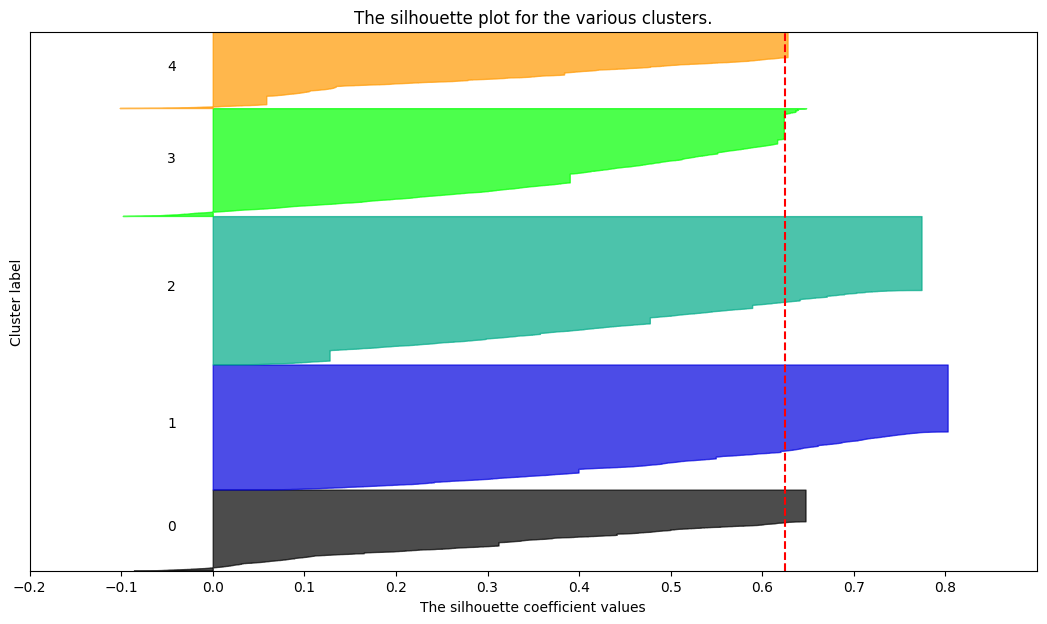

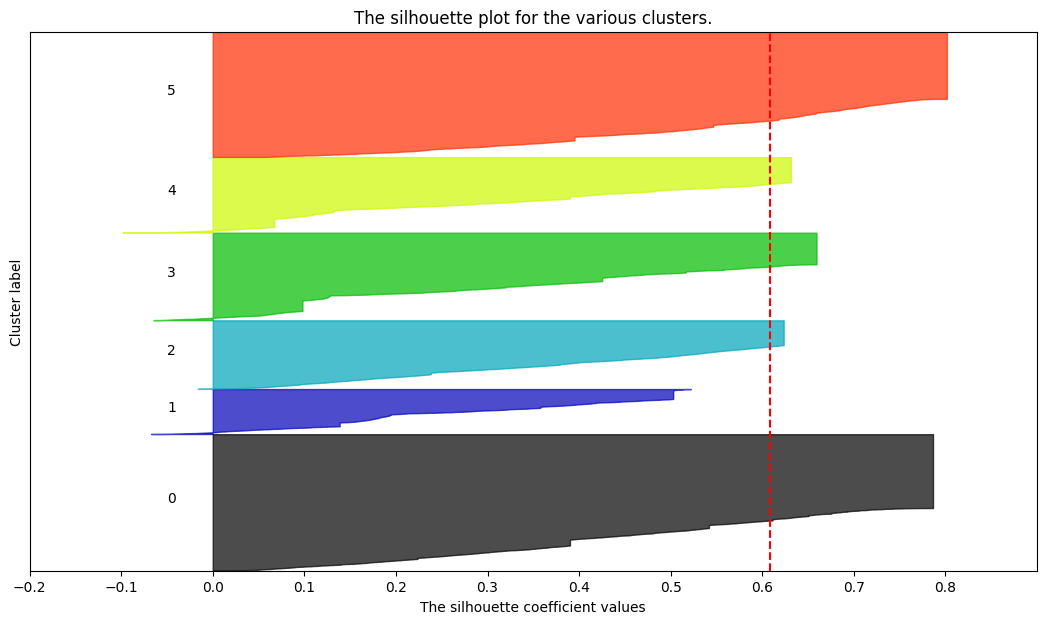

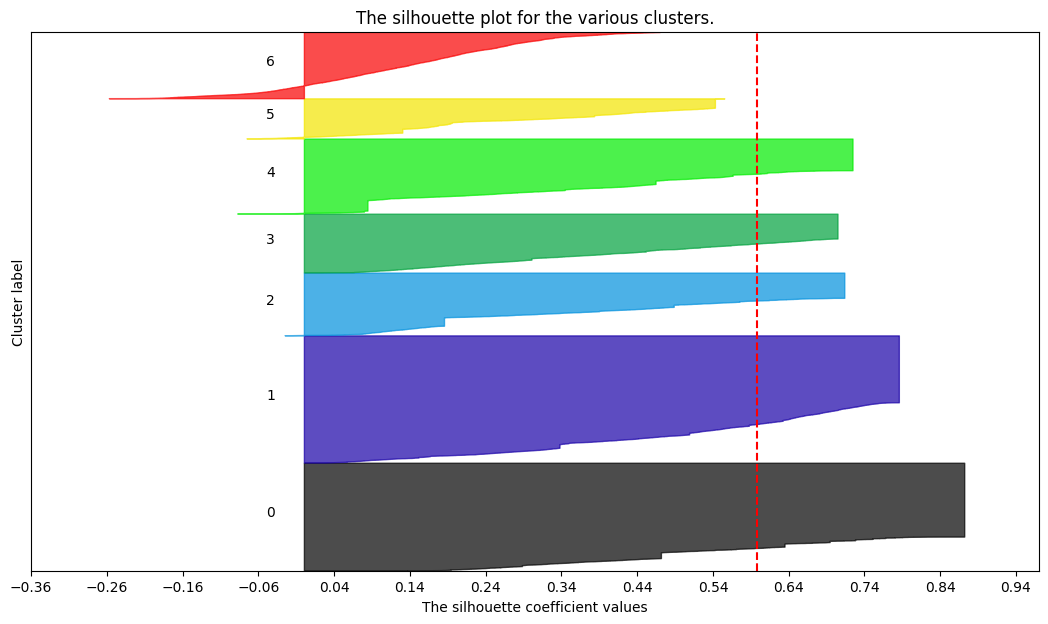

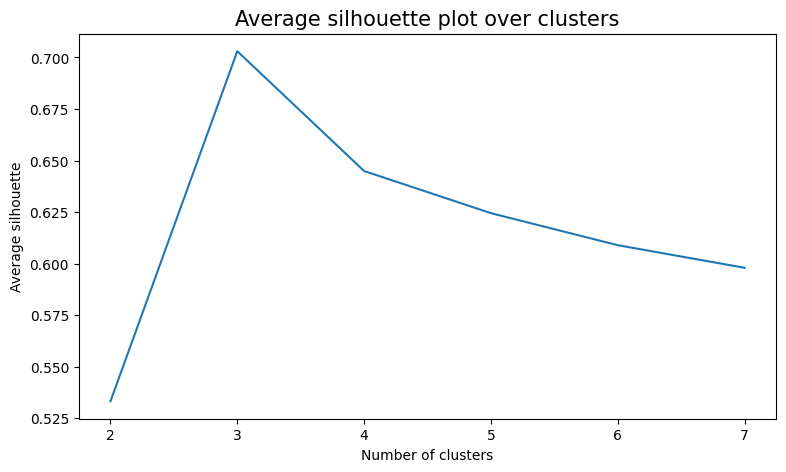

In [47]:

avg_silhouette = []
for nclus in range_clusters:
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))

    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=42)
    cluster_labels = kmclust.fit_predict(df[preferences_cols])

    silhouette_avg = silhouette_score(df[preferences_cols], cluster_labels, metric='cosine')
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df[preferences_cols], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])

    plt.ylim([0, len(df[preferences_cols]) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))
    

plt.figure(figsize=(9,5))
plt.plot(range_clusters[1:], 
         avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

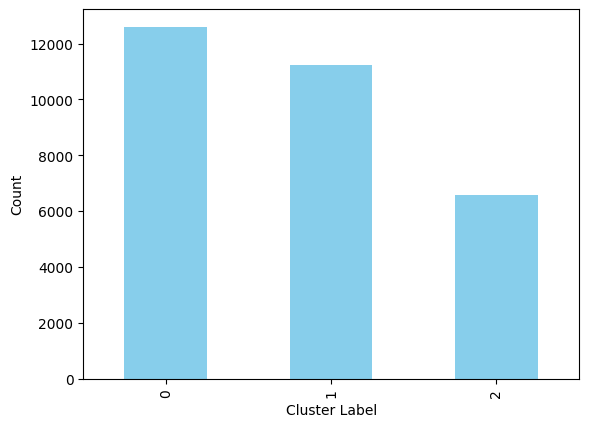

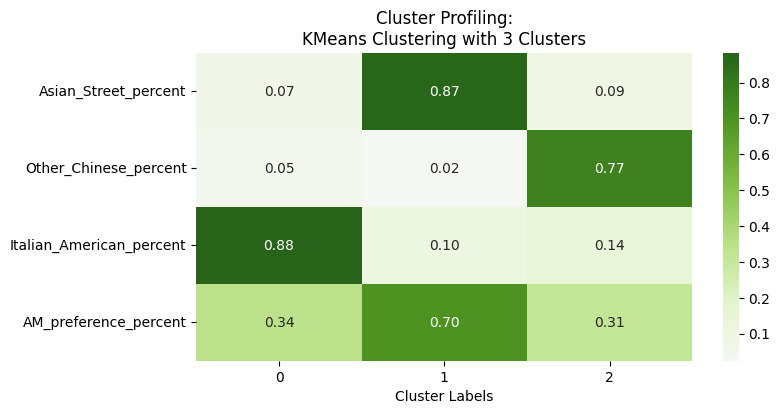

In [48]:

number_clusters = 3
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=42)
km_labels = kmclust.fit_predict(df[preferences_cols])


normalized_df = pd.DataFrame(df[preferences_cols], columns=preferences_cols, index=df.index)

df_concat = pd.concat((normalized_df, pd.Series(km_labels, name='labels', index=df.index)), axis=1)

#r2 = get_rsq(df_concat, preferences_cols, 'labels')

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

fig, ax = plt.subplots(figsize=(8,4))
km_profile = df_concat.groupby('labels').mean().T
sns.heatmap(km_profile,
            center=0, annot=True, cmap="PiYG", fmt=".2f",
            ax=ax)
ax.set_xlabel("Cluster Labels")
ax.set_title("Cluster Profiling:\nKMeans Clustering with 3 Clusters")
plt.show()

In [49]:
silho = silhouette_score(normalized_df, km_labels, metric='cosine')
silhouettes_avgs.append(silho)
silho

0.7030190108470945

<Axes: xlabel='Hierarchical Clustering'>

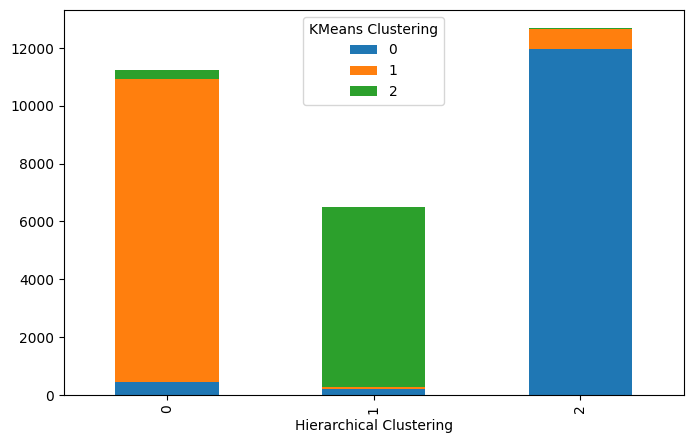

In [50]:
pd.crosstab(
    pd.Series(hc_labels, name="Hierarchical Clustering"),
    pd.Series(km_labels, name="KMeans Clustering")
).plot(kind="bar", figsize=(8, 5), stacked=True)

# SOM Clustering (Emergent SOM)

In [51]:

neigh = 'gaussian'
topol = 'hexagonal'
n_feats = len(preferences_cols)
activation_distc = 'cosine'

som_data = df[preferences_cols].values


In [52]:

# based on "ESOM-Maps: tools for clustering, visualization, and classification with Emergent SOM" 
from numpy.linalg import eig


cov_matrix = np.cov(df[preferences_cols].T)

eigenvalues, _ = eig(cov_matrix)
eigenvalues = sorted(eigenvalues.round(3), reverse=True)
ratio = eigenvalues[0] / eigenvalues[1]
ratio.round(2)


1.84

In [53]:
grid_size = 4_000 
M = np.sqrt(grid_size * ratio).round().astype(int)
N = (grid_size / M).round().astype(int)
print(f"M: {M}, N: {N}")

M: 86, N: 47


In [54]:

neigh = 'gaussian'
topol = 'hexagonal'
n_feats = len(preferences_cols)

#map_size = [(29, 29), (50, 50)]
learning_rates = [0.5] # 0.3, 0.6 
sigmas = [3] # 1, 1.5, 2, 2.5
epochs_list = [500_000]

som_data = df[preferences_cols].values

best_te = float('inf')
best_params = {}

for lr in learning_rates:
    for sigma in sigmas:
        sm = MiniSom(M, N, n_feats, sigma=sigma, learning_rate=lr, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)
        sm.random_weights_init(som_data)

        sm.train_batch(som_data, epochs_list[0])

        qe = sm.quantization_error(som_data)
        te = sm.topographic_error(som_data)

        print(f"LR: {lr}, Sigma: {sigma}, Epochs: {epochs_list[0]} -> QE: {qe:.3f}, TE: {te:.3f}")

        # Update best parameters based on TE
        if te < best_te:
            best_te = te
            best_params = {'learning_rate': lr, 'sigma': sigma, 'epochs': epochs_list[0]}


best_params

C:\Users\Elcano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


LR: 0.5, Sigma: 3, Epochs: 500000 -> QE: 0.009, TE: 0.113


{'learning_rate': 0.5, 'sigma': 3, 'epochs': 500000}

In [55]:


sm = MiniSom(M, N, n_feats, sigma=3, learning_rate=0.5, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)

sm.random_weights_init(som_data)

print("Before training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")

sm.train_batch(som_data, 500_000)

print("After training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")

Before training:
QE: 0.011
TE: 1.0
After training:
QE: 0.009
TE: 0.113


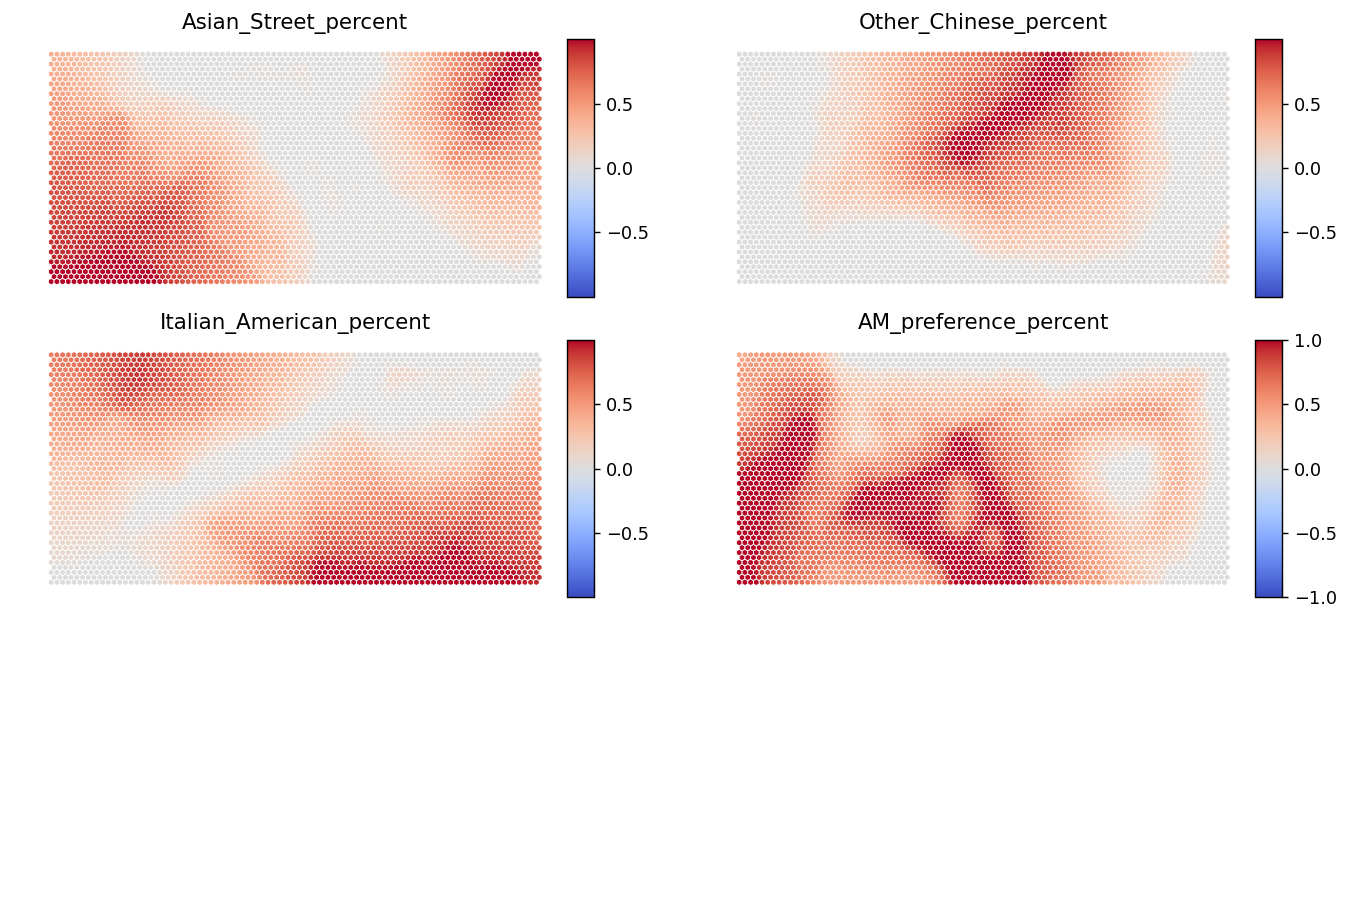

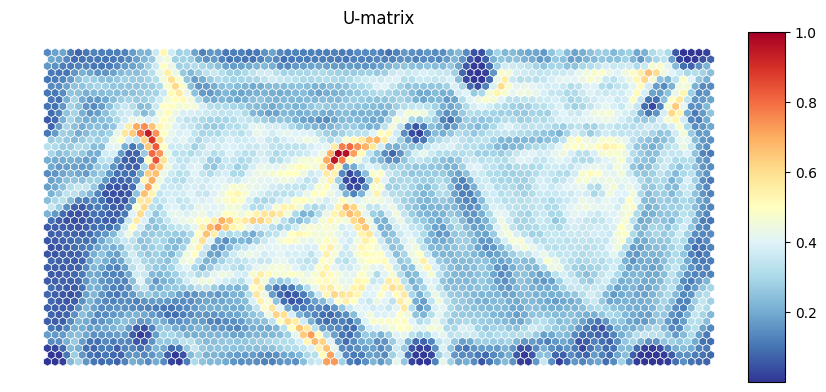

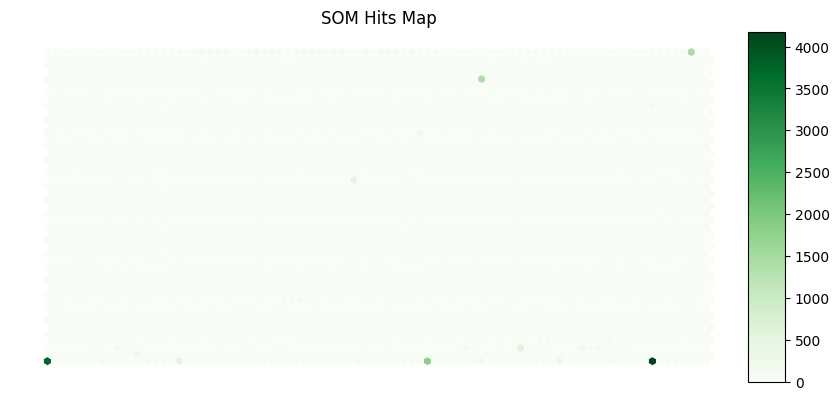

In [56]:

weights = sm.get_weights()
weights.shape
figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )
subfigs = fig.subfigures(3,2,wspace=.15)
colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
for cpi, sf in zip(range(len(preferences_cols)), subfigs.flatten()):
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    #colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)
    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=preferences_cols[cpi],
                    cmap=cm.coolwarm,
                    )
    
    
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    )


hitsmatrix = sm.activation_response(df[preferences_cols].values)
fig = plt.figure(figsize=figsize)
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    )

In [57]:
weights_flat = sm.get_weights().reshape((M*N),len(preferences_cols))
weights_flat.shape

(4042, 4)

## KMeans on SOM 

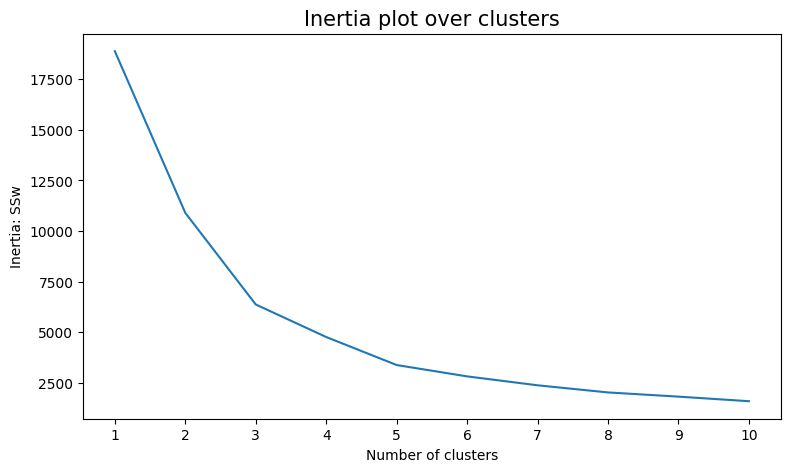

In [58]:


range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=42)
    kmclust.fit(df[preferences_cols])
    inertia.append(kmclust.inertia_)
    
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)
plt.show()

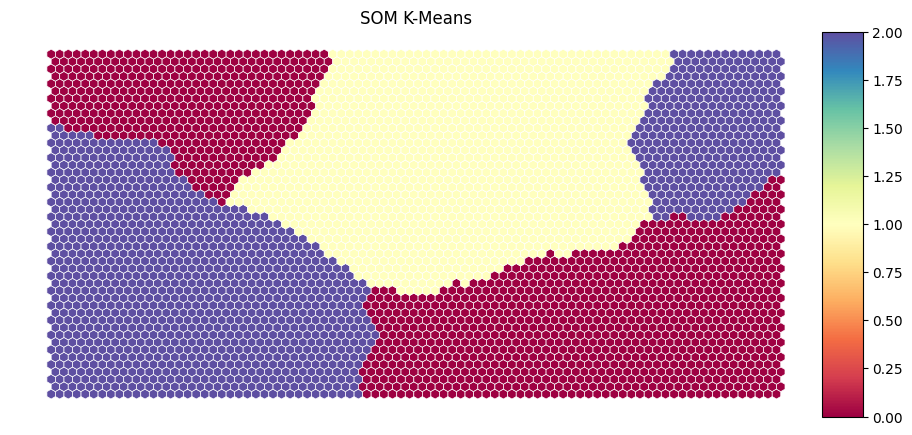

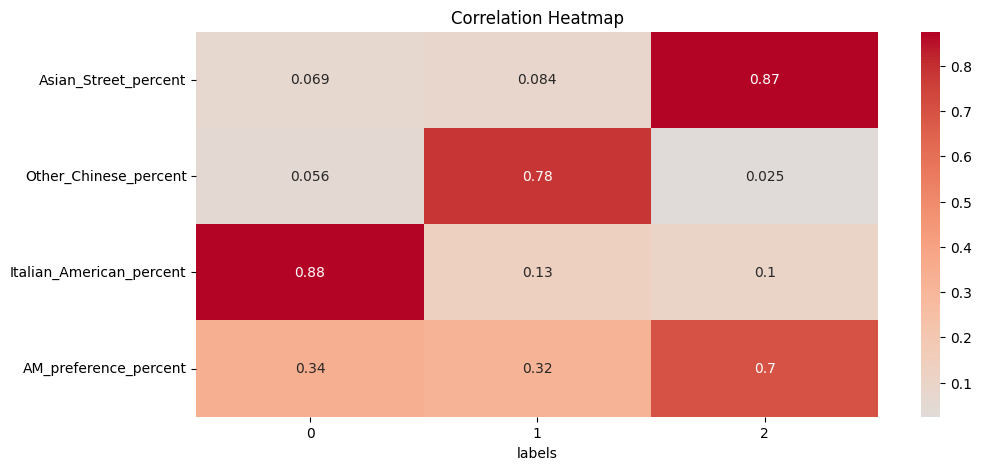

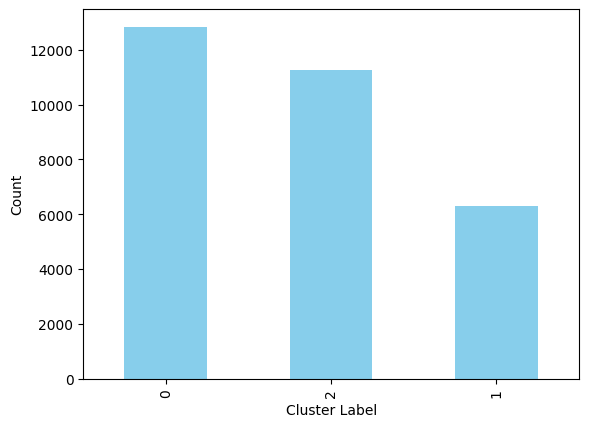

In [59]:


kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)

nodeclus_labels = kmeans.fit_predict(weights_flat)

kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )


nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=preferences_cols)
df_nodes['label'] = nodeclus_labels

# shape df.shape[0], 2 dimension 
bmu_index = np.array([sm.winner(x) for x in df[preferences_cols].values])
som_final_labels = [kmeans_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[preferences_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [60]:

silh = silhouette_score(df[preferences_cols], som_final_labels, metric='cosine')
silhouettes_avgs.append(silh)
silh

0.7055043405467555

## Hierarchical on SOM 

C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\1934158007.py:15: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)


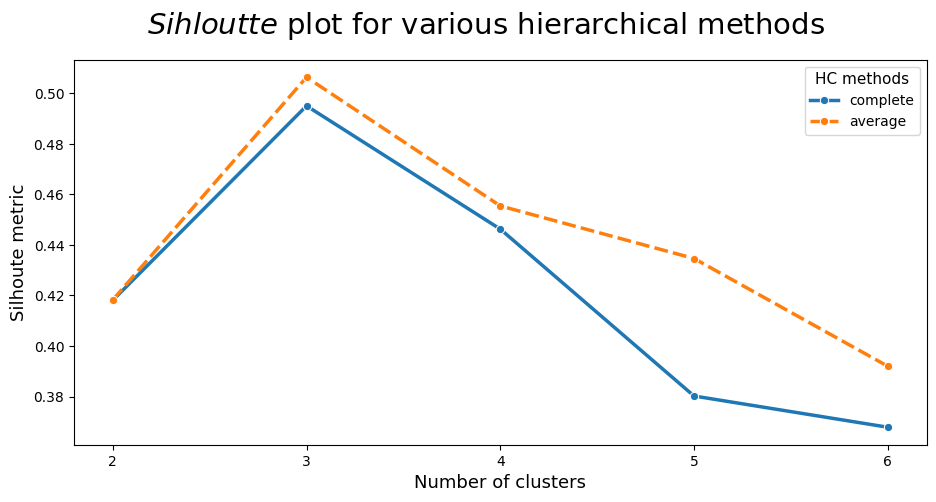

In [61]:

weights_flat = pd.DataFrame(weights_flat, columns=preferences_cols)


hc_methods = ["complete", "average"] # ward doesnt work with cosine distances / single always bad
max_nclus = 6
r2_hc = np.vstack([ get_silhouette_hc(weights_flat, 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=2, 
                              dist="cosine") 
                              for link in hc_methods])

r2_hc_methods = pd.DataFrame(r2_hc.T, index=range(2, max_nclus + 1), columns=hc_methods)
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(2, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("Silhoute metric", fontsize=13)
fig.suptitle("$Sihloutte$ plot for various hierarchical methods", fontsize=21)
plt.show()

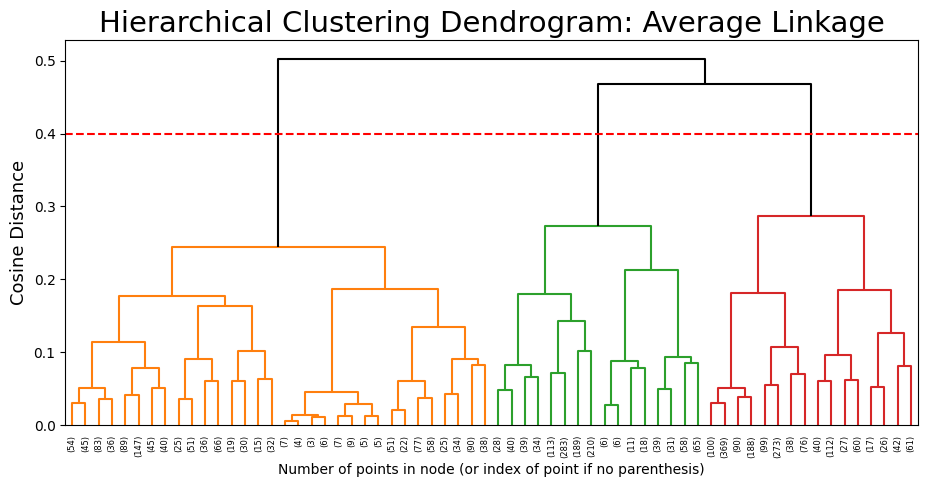

In [62]:

link = 'average'
distance = 'cosine'
hclust = AgglomerativeClustering(linkage=link, metric=distance, distance_threshold=0, n_clusters=None)

hclust.fit_predict(weights_flat)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)
for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)

fig = plt.figure(figsize=(11,5))
y_threshold = 0.4
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {link.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()


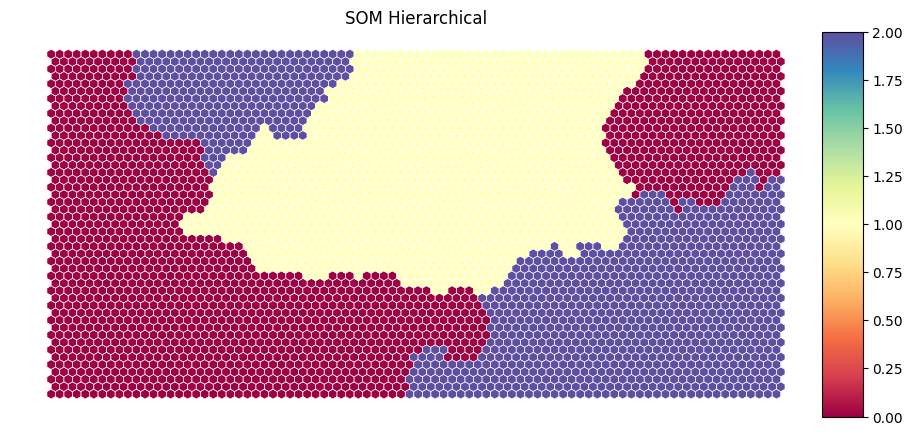

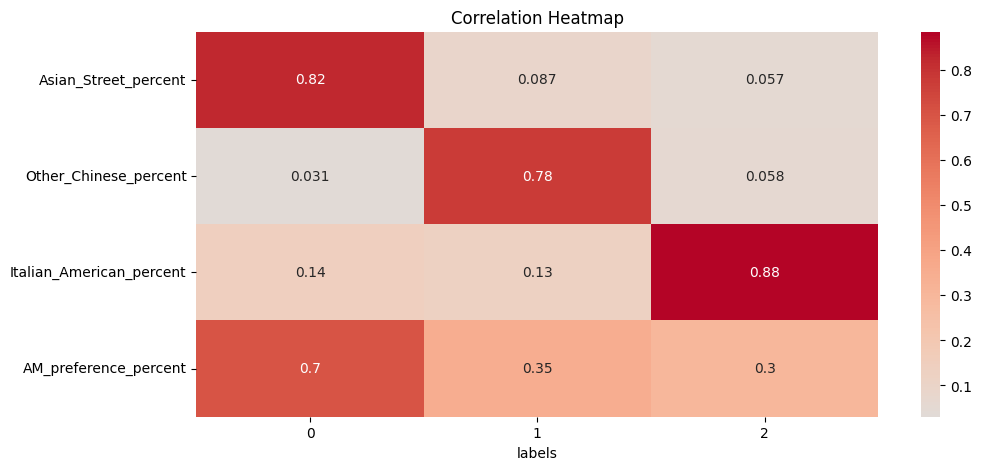

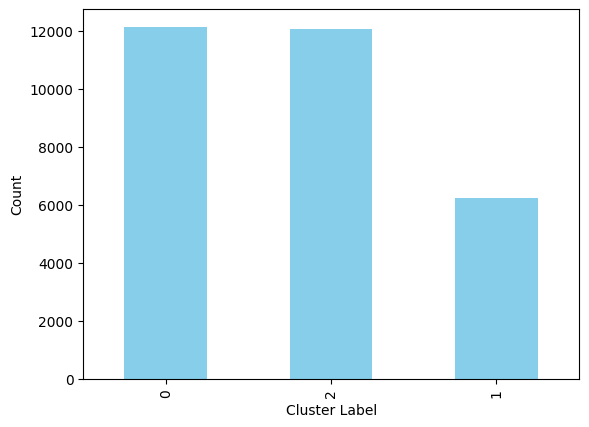

In [63]:

hc_clust = AgglomerativeClustering(n_clusters=3, linkage="average", metric="cosine")
nodeclus_labels = hc_clust.fit_predict(weights_flat)

hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )



nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=preferences_cols)
df_nodes['label'] = nodeclus_labels

bmu_index = np.array([sm.winner(x) for x in df[preferences_cols].values])

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[preferences_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()


In [64]:

silho = silhouette_score(df[preferences_cols], som_final_labels, metric='cosine')
silhouettes_avgs.append(silho)

silho

0.6656719267123375

# Gaussian Mixture Model

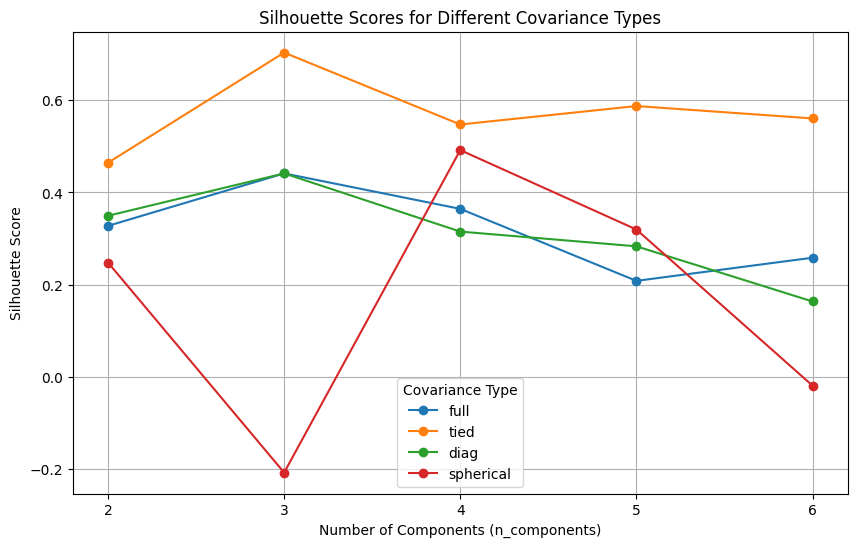

In [65]:

n_components = np.arange(2, 7)
cov_types = ['full', 'tied', 'diag', 'spherical']
scores = {}

for cova in cov_types:
    models = [GaussianMixture(n, covariance_type=cova, n_init=10, random_state=42).fit(df[preferences_cols]) 
              for n in n_components]
    
    scores[cova] = [silhouette_score(df[preferences_cols], model.predict(df[preferences_cols]), metric='cosine') 
                    for model in models]

plt.figure(figsize=(10, 6))
for cova in cov_types:
    plt.plot(n_components, scores[cova], marker='o', label=f'{cova}')
plt.title('Silhouette Scores for Different Covariance Types')
plt.xlabel('Number of Components (n_components)')
plt.ylabel('Silhouette Score')
plt.xticks(n_components)
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


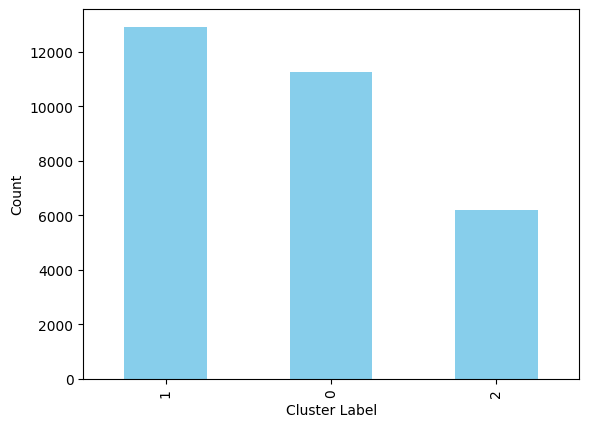

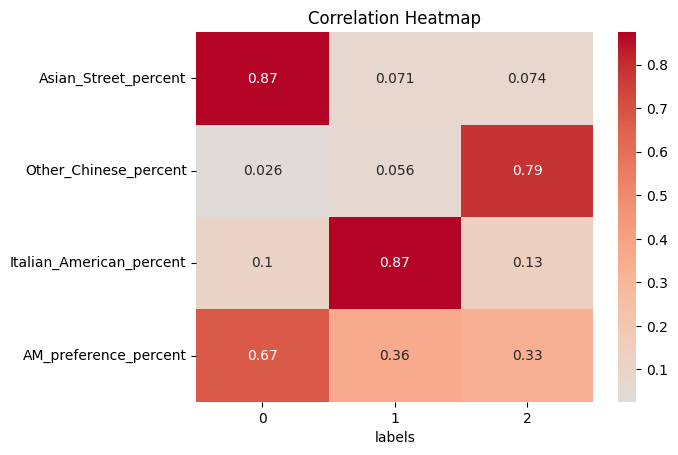

In [66]:

gm = GaussianMixture(n_components=3, covariance_type='tied', n_init=10, random_state=42)
gm_labels = gm.fit_predict(df[preferences_cols])

df_concat = pd.concat((df[preferences_cols], pd.Series(gm_labels, name='labels', index=df.index)), axis=1)

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [67]:

silho = silhouette_score(df[preferences_cols], gm_labels, metric='cosine')
silhouettes_avgs.append(silho)
silho

0.7032295572321842

# Comparison of Clustering Methods for Preferences

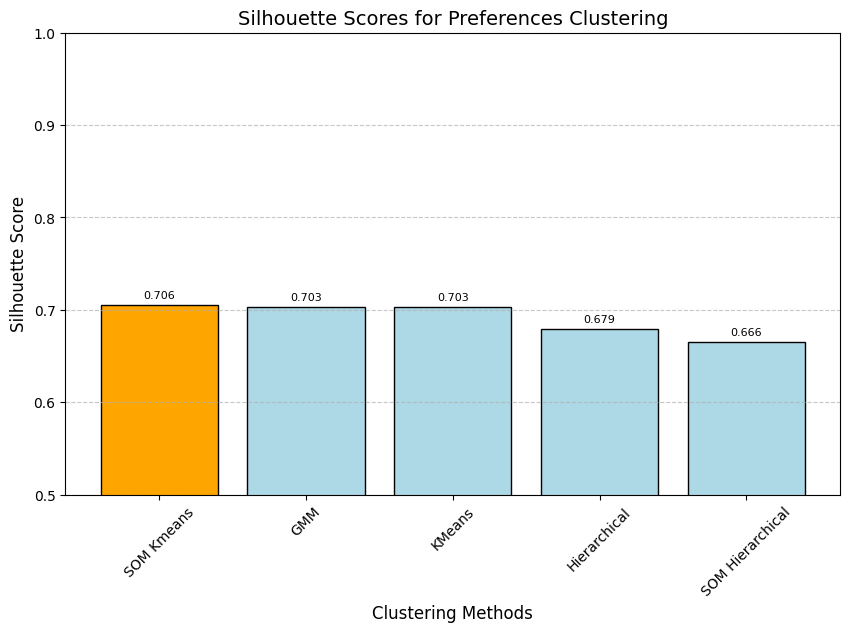

In [68]:

plt.figure(figsize=(10, 6))
methods = ['Hierarchical', 'KMeans', 'SOM Kmeans', "SOM Hierarchical", 'GMM']

sorted_indices = sorted(range(len(silhouettes_avgs)), key=lambda k: silhouettes_avgs[k], reverse=True)
methods = [methods[i] for i in sorted_indices]
silhouettes_avgs = [silhouettes_avgs[i] for i in sorted_indices]


bars = plt.bar(methods, silhouettes_avgs, color='lightblue', edgecolor='black')

max_index = silhouettes_avgs.index(max(silhouettes_avgs))
bars[max_index].set_color('orange')
bars[max_index].set_edgecolor('black')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{silhouettes_avgs[i]:.3f}',
             ha='center', va='bottom', fontsize=8, color='black')

plt.title('Silhouette Scores for Preferences Clustering', fontsize=14)
plt.xlabel('Clustering Methods', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.ylim(0.5, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.xticks(rotation=45) 
plt.show()

# Final Solution: Kmeans on SOM 

In [69]:

neigh = 'gaussian'
topol = 'hexagonal'
n_feats = len(preferences_cols)
activation_distc = 'cosine'

cov_matrix = np.cov(df[preferences_cols].T)
eigenvalues, _ = eig(cov_matrix)
eigenvalues = sorted(eigenvalues.round(3), reverse=True)
ratio = eigenvalues[0] / eigenvalues[1]
ratio.round(2)

grid_size = 4_000 
M = np.sqrt(grid_size * ratio).round().astype(int)
N = (grid_size / M).round().astype(int)


sm = MiniSom(M, N, n_feats, sigma=3, learning_rate=0.5, neighborhood_function=neigh, topology=topol, random_seed=42, activation_distance=activation_distc)

sm.random_weights_init(som_data)

print("Before training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")

sm.train_batch(som_data, 500_000)

print("After training:")
print(f"QE: {sm.quantization_error(som_data).round(3)}")
print(f"TE: {sm.topographic_error(som_data).round(3)}")


weights = sm.get_weights()

Before training:


C:\Users\Elcano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


QE: 0.011
TE: 1.0
After training:
QE: 0.009
TE: 0.113


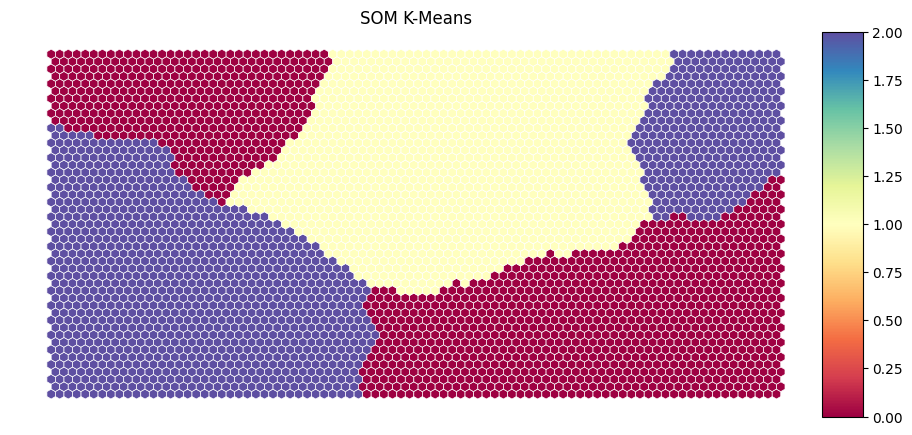

<Figure size 1100x500 with 0 Axes>

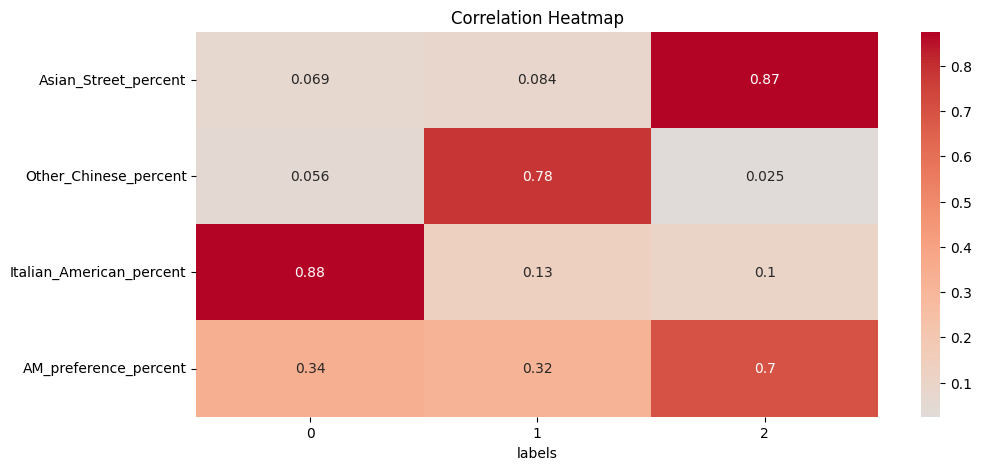

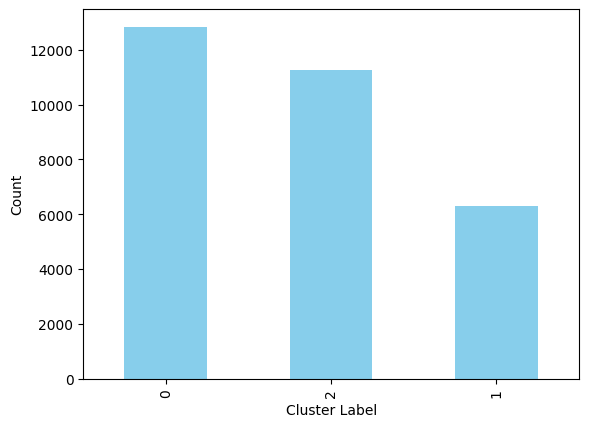

In [70]:

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)

nodeclus_labels = kmeans.fit_predict(weights_flat)

kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=(11,5))
colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))
fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )


nodes = weights_flat
df_nodes = pd.DataFrame(nodes, columns=preferences_cols)
df_nodes['label'] = nodeclus_labels

# shape df.shape[0], 2 dimension 
bmu_index = np.array([sm.winner(x) for x in df[preferences_cols].values])
som_final_labels = [kmeans_matrix[i[0]][i[1]] for i in bmu_index]

fig = plt.figure(figsize=(11,5))
df_concat = pd.concat((df[preferences_cols], pd.Series(som_final_labels, name='labels', index=df.index)), axis=1)
fig = plt.figure(figsize=(11,5))
sns.heatmap(df_concat.groupby("labels").mean().T, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

df_concat['labels'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

In [71]:

silh = silhouette_score(df[preferences_cols], som_final_labels, metric='cosine', random_state=42)
silh

0.7055043405467555

# Merging the Perspectives

In [97]:
columns_to_use = ['total_spent_log',
                'total_orders_log',
                'spend_per_vendor_log',
                "total_spent_chain_log", 
                "Asian_Street_percent",
                "Other_Chinese_percent",
                "Italian_American_percent",
                "AM_preference_percent",]

In [98]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
value_cols = [
    'total_spent_log',
    'total_orders_log',
    'spend_per_vendor_log',
    "total_spent_chain_log"
]

preferences_cols = [
    "Asian_Street_percent",
    "Other_Chinese_percent",
    "Italian_American_percent",
    "AM_preference_percent" 
]

df_RFM = df[value_cols].copy()
df_vb = df[value_cols].copy()
df_prf = df[preferences_cols].copy()

In [99]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_value = KMeans(
    n_clusters=2,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(df_vb)

kmeans_preference = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
preferences_labels = kmeans_preference.fit_predict(df[preferences_cols])

df['value_labels'] = value_labels
df['preferences_labels'] = preferences_labels

# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_value = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(df_vb)

hc_pref = AgglomerativeClustering(
    n_clusters=3,
    linkage="average",
    metric="cosine"
)
preferences_labels = hc_pref.fit_predict(df_prf)

df['value_labels'] = value_labels
df['preferences_labels'] = preferences_labels

In [100]:
# Count label frequencies (contigency table)

pd.crosstab(df['value_labels'],
            df['preferences_labels'])

preferences_labels     0     1     2
value_labels                        
0                   5391  5913  3073
1                   7205  5333  3490

In [101]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'preferences_labels'])\
    [columns_to_use].mean()
df_centroids

total_spent_log  total_orders_log  \
value_labels preferences_labels                                      
0            0                          0.678978          0.445857   
             1                          0.719086          0.379922   
             2                          0.645204          0.482894   
1            0                          0.508379          0.131613   
             1                          0.547673          0.110156   
             2                          0.463995          0.144530   

                                 spend_per_vendor_log  total_spent_chain_log  \
value_labels preferences_labels                                                
0            0                               0.527073               0.594197   
             1                               0.597747               0.628438   
             2                               0.435019               0.588642   
1            0                               0.463417               0.249324   
             1                               0.525540               0.239695   
             2                               0.376917               0.322521   

                                 Asian_Street_percent  Other_Chinese_percent  \
value_labels preferences_labels                                                
0            0                               0.103356               0.079694   
             1                               0.825631               0.031163   
             2                               0.128375               0.673277   
1            0                               0.040647               0.026841   
             1                               0.923242               0.016436   
             2                               0.053389               0.850224   

                                 Italian_American_percent  \
value_labels preferences_labels                             
0            0                                   0.816950   
             1                                   0.143207   
             2                                   0.198348   
1            0                                   0.932512   
             1                                   0.060322   
             2                                   0.096387   

                                 AM_preference_percent  
value_labels preferences_labels                         
0            0                                0.364523  
             1                                0.745226  
             2                                0.334868  
1            0                                0.326739  
             1                                0.648593  
             2                                0.294540

In [102]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

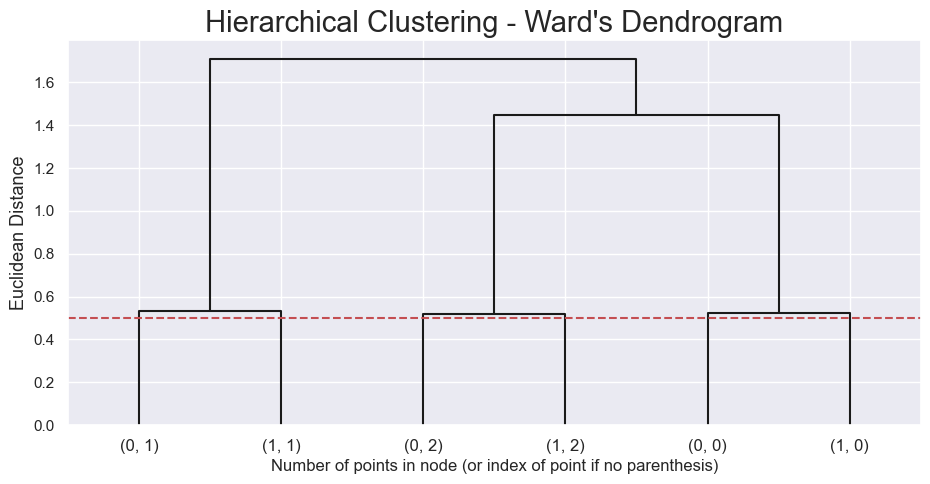

In [103]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = .5
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [104]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent_log  total_orders_log  \
value_labels preferences_labels                                      
0            0                          0.678978          0.445857   
             1                          0.719086          0.379922   
             2                          0.645204          0.482894   
1            0                          0.508379          0.131613   
             1                          0.547673          0.110156   
             2                          0.463995          0.144530   

                                 spend_per_vendor_log  total_spent_chain_log  \
value_labels preferences_labels                                                
0            0                               0.527073               0.594197   
             1                               0.597747               0.628438   
             2                               0.435019               0.588642   
1            0                               0.463417               0.249324   
             1                               0.525540               0.239695   
             2                               0.376917               0.322521   

                                 Asian_Street_percent  Other_Chinese_percent  \
value_labels preferences_labels                                                
0            0                               0.103356               0.079694   
             1                               0.825631               0.031163   
             2                               0.128375               0.673277   
1            0                               0.040647               0.026841   
             1                               0.923242               0.016436   
             2                               0.053389               0.850224   

                                 Italian_American_percent  \
value_labels preferences_labels                             
0            0                                   0.816950   
             1                                   0.143207   
             2                                   0.198348   
1            0                                   0.932512   
             1                                   0.060322   
             2                                   0.096387   

                                 AM_preference_percent  hclust_labels  
value_labels preferences_labels                                        
0            0                                0.364523              4  
             1                                0.745226              3  
             2                                0.334868              5  
1            0                                0.326739              2  
             1                                0.648593              1  
             2                                0.294540              0

In [105]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 4, (0, 1): 3, (0, 2): 5, (1, 0): 2, (1, 1): 1, (1, 2): 0}

In [106]:
df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['preferences_labels'])
    ], axis=1
)

df_ 

customer_id  customer_age  vendor_count  product_count  is_chain  \
0      1b8f824d5e            18             2              5         1   
1      5d272b9dcb            17             2              2         2   
2      f6d1b2ba63            38             1              2         2   
3      180c632ed8            25             2              3         1   
4      4eb37a6705            20             2              5         0   
...           ...           ...           ...            ...       ...   
30400  f4e366c281            30             1              1         1   
30401  f6b6709018            24             1              1         0   
30402  f74ad8ce3f            24             1              1         1   
30403  f7b19c0241            34             1              1         0   
30404  fd40d3b0e0            30             1              1         0   

       first_order  last_order  CUI_American  CUI_Asian  CUI_Beverages  ...  \
0              0.0    0.011111      0.000000   0.000000       0.000000  ...   
1              0.0    0.011111      0.055318   0.022287       0.000000  ...   
2              0.0    0.011111      0.039698   0.000000       0.000000  ...   
3              0.0    0.022222      0.000000   0.047782       0.000000  ...   
4              0.0    0.022222      0.062869   0.142543       0.000000  ...   
...            ...         ...           ...        ...            ...  ...   
30400          0.0    0.000000      0.000000   0.000000       0.093748  ...   
30401          0.0    0.000000      0.077843   0.000000       0.000000  ...   
30402          0.0    0.000000      0.000000   0.000000       0.000000  ...   
30403          0.0    0.000000      0.000000   0.041957       0.000000  ...   
30404          0.0    0.000000      0.000000   0.000000       0.000000  ...   

       last_promo_NO PROMO  payment_method_CARD  payment_method_CASH  \
0                    False                False                False   
1                    False                False                False   
2                    False                False                 True   
3                    False                False                False   
4                     True                False                False   
...                    ...                  ...                  ...   
30400                False                False                False   
30401                False                False                False   
30402                 True                False                False   
30403                False                False                False   
30404                 True                False                 True   

       payment_method_DIGI  customer_activity_Active  \
0                     True                     False   
1                     True                     False   
2                    False                     False   
3                     True                     False   
4                     True                     False   
...                    ...                       ...   
30400                 True                     False   
30401                 True                     False   
30402                 True                     False   
30403                 True                     False   
30404                False                     False   

       customer_activity_Churning  customer_activity_Recent  value_labels  \
0                            True                     False             1   
1                            True                     False             1   
2                            True                     False             1   
3                            True                     False             0   
4                            True                     False             1   
...                           ...                       ...           ...   
30400                        True                     False             1   
30401         

In [107]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[columns_to_use]

total_spent_log  total_orders_log  spend_per_vendor_log  \
merged_labels                                                            
0                     0.463995          0.144530              0.376917   
1                     0.547673          0.110156              0.525540   
2                     0.508379          0.131613              0.463417   
3                     0.719086          0.379922              0.597747   
4                     0.678978          0.445857              0.527073   
5                     0.645204          0.482894              0.435019   

               total_spent_chain_log  Asian_Street_percent  \
merged_labels                                                
0                           0.322521              0.053389   
1                           0.239695              0.923242   
2                           0.249324              0.040647   
3                           0.628438              0.825631   
4                           0.594197              0.103356   
5                           0.588642              0.128375   

               Other_Chinese_percent  Italian_American_percent  \
merged_labels                                                    
0                           0.850224                  0.096387   
1                           0.016436                  0.060322   
2                           0.026841                  0.932512   
3                           0.031163                  0.143207   
4                           0.079694                  0.816950   
5                           0.673277                  0.198348   

               AM_preference_percent  
merged_labels                         
0                           0.294540  
1                           0.648593  
2                           0.326739  
3                           0.745226  
4                           0.364523  
5                           0.334868

In [108]:
# Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

0
merged_labels      
0              3490
1              5333
2              7205
3              5913
4              5391
5              3073

In [109]:
# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

merged_labels     0
0        (1, 2)  3490
1        (1, 1)  5333
2        (1, 0)  7205
3        (0, 1)  5913
4        (0, 0)  5391
5        (0, 2)  3073

In [110]:
df_counts['value_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['preferences_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

merged_labels     0  value_labels  preferences_labels
0        (1, 2)  3490             1                   2
1        (1, 1)  5333             1                   1
2        (1, 0)  7205             1                   0
3        (0, 1)  5913             0                   1
4        (0, 0)  5391             0                   0
5        (0, 2)  3073             0                   2

In [111]:
df_counts.pivot(values=0, index='value_labels', columns='preferences_labels')

preferences_labels     0     1     2
value_labels                        
0                   5391  5913  3073
1                   7205  5333  3490

In [112]:
# Setting df to have the final valeu, preferences and merged clusters
df = df_.copy()

## Cluster Analysis

In [113]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=label,
C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x=label,
C:\Users\Elcano\AppData\Local\Temp\ipykernel_9512\2074131698.py:35: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x=label,


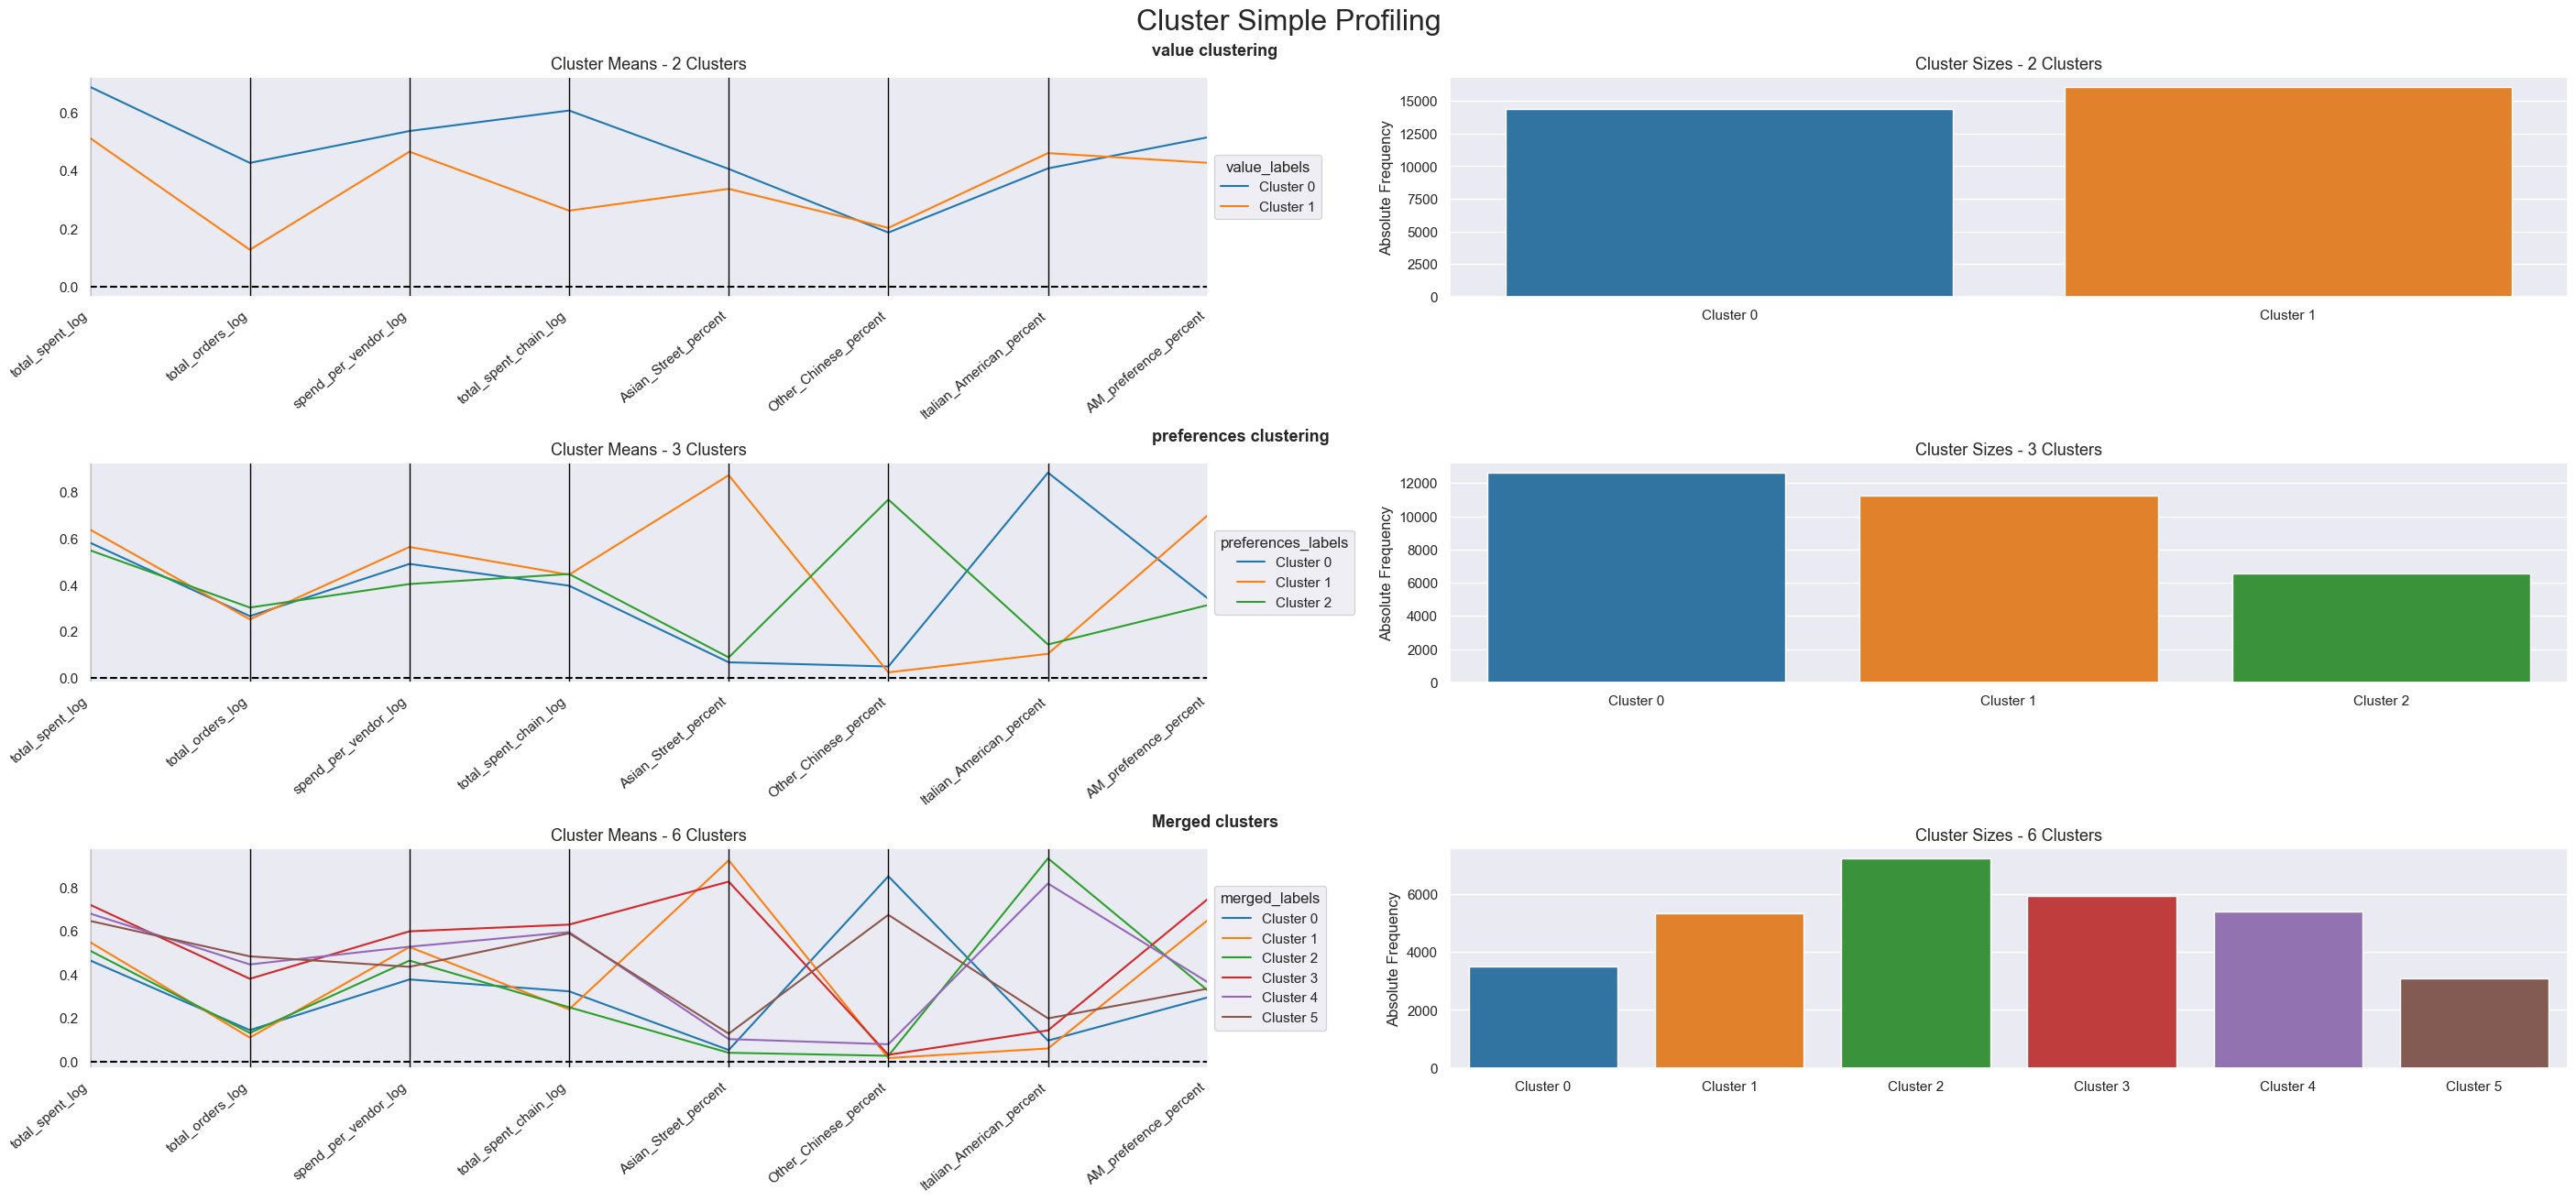

In [116]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[columns_to_use + ['value_labels', 'preferences_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'preferences_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["value clustering", "preferences clustering", "Merged clusters"]
)

## Profiling with unused / categorical features

In [139]:
new_cat_cols = [['customer_region_2360',
 'customer_region_2440',
 'customer_region_2490',
 'customer_region_4140',
 'customer_region_4660',
 'customer_region_8370',
 'customer_region_8550',
 'customer_region_8670',
 'last_promo_DELIVERY',
 'last_promo_DISCOUNT',
 'last_promo_FREEBIE',
 'last_promo_NO PROMO',
 'payment_method_CARD',
 'payment_method_CASH',
 'payment_method_DIGI',
 'customer_activity_Active',
 'customer_activity_Churning',
 'customer_activity_Recent']]

### Region

In [140]:
region = df[['merged_labels',
            'customer_region_2360',
 'customer_region_2440',
 'customer_region_2490',
 'customer_region_4140',
 'customer_region_4660',
 'customer_region_8370',
 'customer_region_8550',
 'customer_region_8670']].groupby(['merged_labels']).sum()

region

customer_region_2360  customer_region_2440  \
merged_labels                                               
0                              2206                   376   
1                               898                   167   
2                              1671                   267   
3                               472                    95   
4                              1111                   136   
5                              1948                   375   

               customer_region_2490  customer_region_4140  \
merged_labels                                               
0                               135                    56   
1                                70                    77   
2                                77                   522   
3                                25                    21   
4                                37                   122   
5                               102                    26   

               customer_region_4660  customer_region_8370  \
merged_labels                                               
0                               618                     9   
1                               584                   253   
2                              3707                    53   
3                               452                   184   
4                              3266                    23   
5                               539                     3   

               customer_region_8550  customer_region_8670  
merged_labels                                              
0                                 0                    90  
1                                24                  3260  
2                                11                   897  
3                                31                  4633  
4                                 7                   689  
5                                 2                    78

In [141]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

In [143]:
conditions = [
    df['customer_region_2360'] == 1,
    df['customer_region_2440'] == 1,
    df['customer_region_2490'] == 1,
    df['customer_region_4140'] == 1,
    df['customer_region_4660'] == 1,
    df['customer_region_8370'] == 1,
    df['customer_region_8550'] == 1,
    df['customer_region_8670'] == 1,
]
choices = ['2360', '2440', '2490', '4140', '4660', '8370', '8550', '8670']

df['region_name'] = np.select(conditions, choices, default='Unknown')


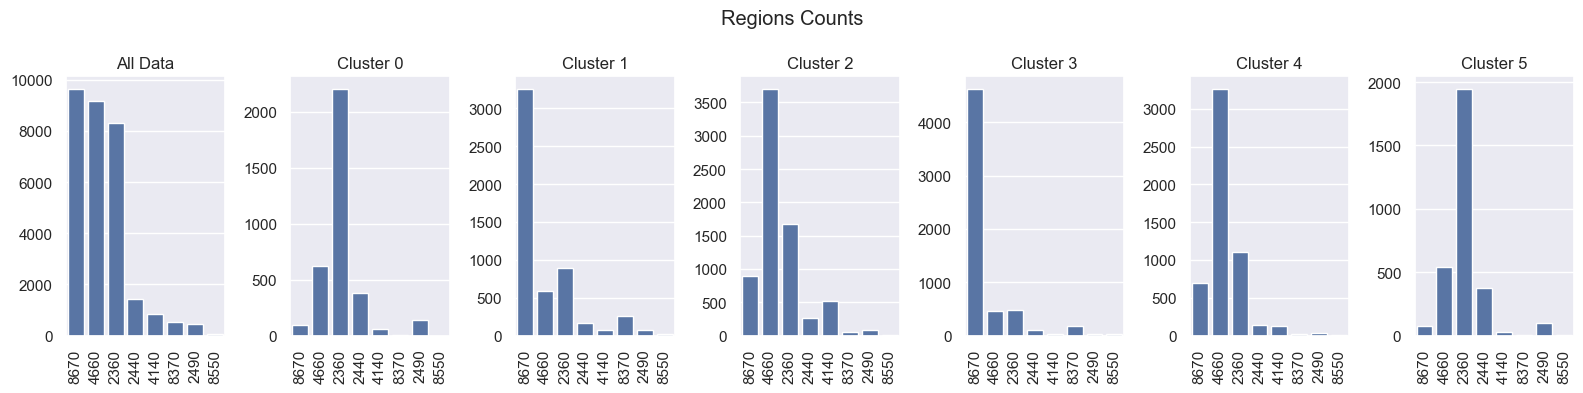

In [144]:
fig, axes = plt.subplots(
    1, 
    df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
    figsize=(16, 4),
    tight_layout=True,
)

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        sns.countplot(
            data=df, 
            x='region_name', 
            order=df['region_name'].value_counts().index,
            ax=ax
        )
        ax.set_title("All Data")
    else:    
        sns.countplot(
            data=df[df['merged_labels'] == i-1], 
            x='region_name', 
            order=df['region_name'].value_counts().index,
            ax=ax
        )
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Regions Counts")
plt.show()

In [145]:
merged_counts = df[['merged_labels']].groupby(['merged_labels']).value_counts()
merged_counts

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

<Axes: xlabel='merged_labels'>

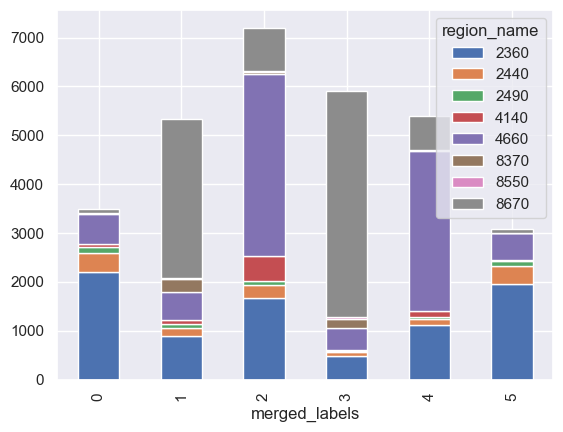

In [146]:
df_cl_promo = df.groupby([
    "merged_labels", 
    "region_name",
    ])['region_name'].size().unstack()

df_cl_promo


df_cl_promo.plot.bar(stacked=True)

### Promotion

In [125]:
promotion = df[['merged_labels',
            'last_promo_DELIVERY',
            'last_promo_DISCOUNT',
            'last_promo_FREEBIE',
            'last_promo_NO PROMO']].groupby(['merged_labels']).sum()

promotion

last_promo_DELIVERY  last_promo_DISCOUNT  last_promo_FREEBIE  \
merged_labels                                                                 
0                              899                  606                 448   
1                             1508                  783                 813   
2                             1649                 1218                 865   
3                              873                  658                 937   
4                              672                  666                 683   
5                              473                  390                 424   

               last_promo_NO PROMO  
merged_labels                       
0                             1537  
1                             2229  
2                             3473  
3                             3445  
4                             3370  
5                             1786

In [120]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

In [128]:
conditions = [
    df['last_promo_DELIVERY'] == 1,
    df['last_promo_DISCOUNT'] == 1,
    df['last_promo_FREEBIE'] == 1,
    df['last_promo_NO PROMO'] == 1,
]
choices = ['DELIVERY', 'DISCOUNT', 'FREEBIE', 'NO PROMO']

df['promotion_type'] = np.select(conditions, choices, default='Unknown')


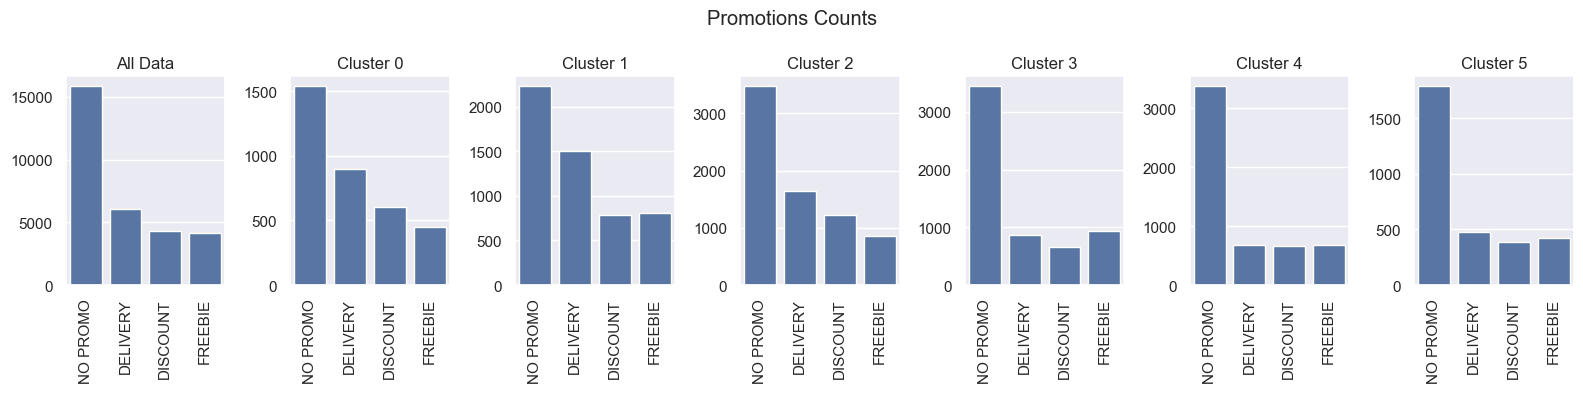

In [129]:
fig, axes = plt.subplots(
    1, 
    df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
    figsize=(16, 4),
    tight_layout=True,
)

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        sns.countplot(
            data=df, 
            x='promotion_type', 
            order=df['promotion_type'].value_counts().index,
            ax=ax
        )
        ax.set_title("All Data")
    else:    
        sns.countplot(
            data=df[df['merged_labels'] == i-1], 
            x='promotion_type', 
            order=df['promotion_type'].value_counts().index,
            ax=ax
        )
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Promotions Counts")
plt.show()

In [130]:
merged_counts = df[['merged_labels']].groupby(['merged_labels']).value_counts()
merged_counts

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

<Axes: xlabel='merged_labels'>

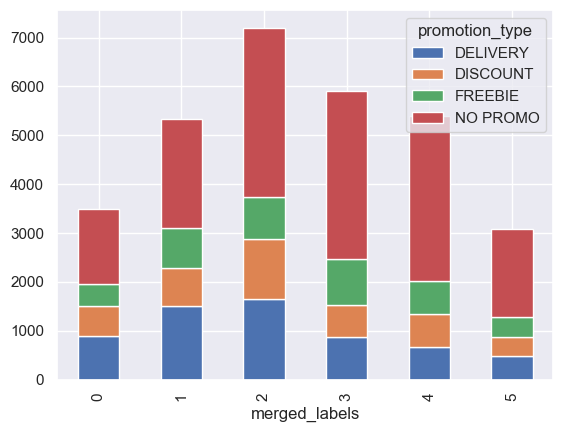

In [132]:
df_cl_promo = df.groupby([
    "merged_labels", 
    "promotion_type",
    ])['promotion_type'].size().unstack()

df_cl_promo


df_cl_promo.plot.bar(stacked=True)


### Recency

In [133]:
recency = df[['merged_labels',
             'customer_activity_Active',
             'customer_activity_Churning',
             'customer_activity_Recent']].groupby(['merged_labels']).sum()

recency

customer_activity_Active  customer_activity_Churning  \
merged_labels                                                         
0                                  1076                        1748   
1                                  1332                        2685   
2                                  2118                        3420   
3                                  4141                        1319   
4                                  4056                        1050   
5                                  2438                         539   

               customer_activity_Recent  
merged_labels                            
0                                   666  
1                                  1316  
2                                  1667  
3                                   453  
4                                   285  
5                                    96

In [134]:
df[['merged_labels']].groupby(['merged_labels']).value_counts()

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

In [135]:
conditions = [
    df['customer_activity_Active'] == 1,
    df['customer_activity_Churning'] == 1,
    df['customer_activity_Recent'] == 1,
]
choices = ['ACTIVE', 'CHURNING', 'RECENT']

df['activity_type'] = np.select(conditions, choices, default='Unknown')


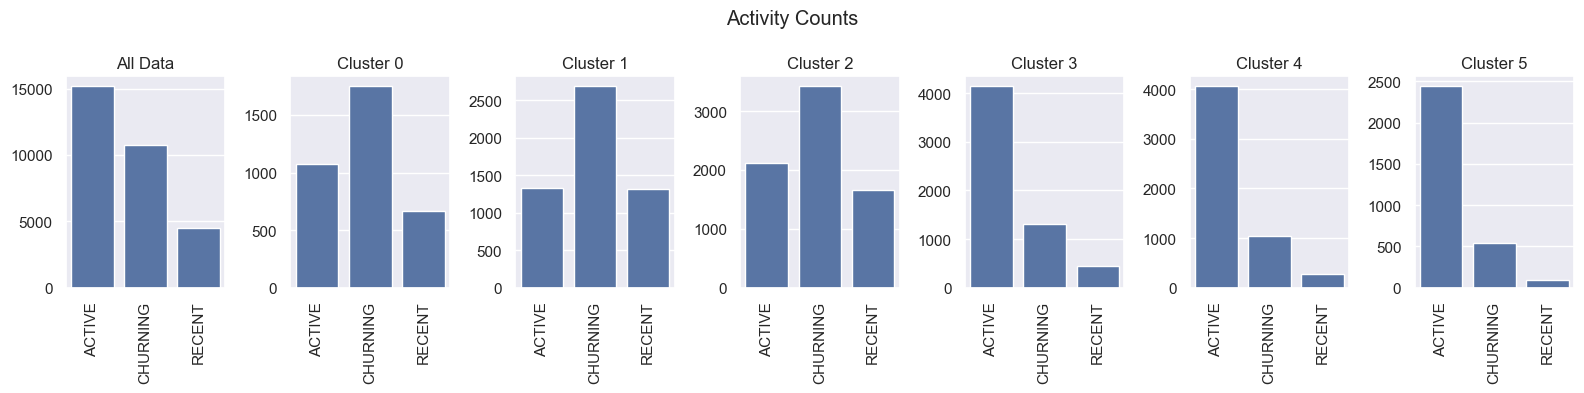

In [136]:
fig, axes = plt.subplots(
    1, 
    df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
    figsize=(16, 4),
    tight_layout=True,
)

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        sns.countplot(
            data=df, 
            x='activity_type', 
            order=df['activity_type'].value_counts().index,
            ax=ax
        )
        ax.set_title("All Data")
    else:    
        sns.countplot(
            data=df[df['merged_labels'] == i-1], 
            x='activity_type', 
            order=df['activity_type'].value_counts().index,
            ax=ax
        )
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Activity Counts")
plt.show()

In [137]:
merged_counts = df[['merged_labels']].groupby(['merged_labels']).value_counts()
merged_counts

merged_labels
0    3490
1    5333
2    7205
3    5913
4    5391
5    3073
Name: count, dtype: int64

<Axes: xlabel='merged_labels'>

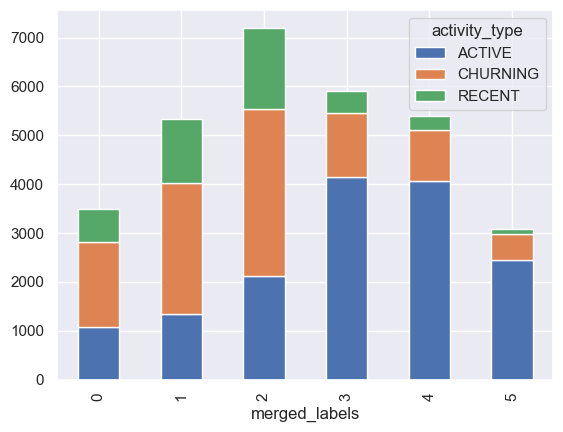

In [138]:
df_cl_promo = df.groupby([
    "merged_labels", 
    "activity_type",
    ])['activity_type'].size().unstack()

df_cl_promo


df_cl_promo.plot.bar(stacked=True)
